# Loading libraries

In [120]:
!pip install missingno

In [121]:
!pip install tqdm 

In [122]:
!pip install imbalanced-learn

In [123]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Wed Nov  2 17:20:09 2022

@author: gxxdx
"""

#////////////////////////////////LOADING DATA/////////////////////////////////

#First we need to import the nedded libaries for this analysis

import os
import statsmodels.api as sm
import statsmodels.stats.diagnostic as d
import statsmodels.stats.stattools as s
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.model_selection import KFold, cross_val_score, RandomizedSearchCV, train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.inspection import permutation_importance
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import LogisticRegression,  RidgeClassifier, ElasticNet
import missingno as msno
import datetime
from tqdm import tqdm
from scipy import stats
from statsmodels.tools.eval_measures import rmse
from statsmodels.miscmodels.ordinal_model import OrderedModel
from imblearn.over_sampling import SMOTE
import pickle

# Define functions

In [124]:
# Define function to calculate exploratory statistics (univariate)
def full_describe(dataframe,variables="all",variability=20,completeness=10): #summary, univariado, describe, analisis descriptivo, describir, analisis exploratorio
    #parameter description:
    #dataframe: Dataset to use in DataFrame format
    #variables: Variables to compute the univariate (EDA) analysis. Posible values: "all", input sequence (ie. "1:8"), 
    #input list of numbers or list of variable's names (ie. '1,4,9' o 'var1,var2,var3')
    #completeness: Minimum of accepted completeness per variable (value vetween 0 and 100)
    #variability: Minimum of accepted variability per variable (posible values: 0, 2, 10, 20, 50, 100)
    print("Describe process started, Time: "+ datetime.datetime.now().strftime("%H:%M:%S"))
    start1 = datetime.datetime.now()
    if variables == "all": #If you wish to analyze all the variables
        #Apply "describe" function and add  adicionar (concatenated) rows with Missing values
        resumen=pd.concat([dataframe.describe(include="all",percentiles =[0,0.01,0.05,0.1,0.25,0.5,0.75,0.9,0.95,0.99,1]), dataframe.isnull().sum().to_frame(name = 'missing').T],sort=False)
    elif ":" in variables: #If you wish to analyze the sequence of variables n1:n2
        #Apply "describe" function and add  adicionar (concatenated) rows with Missing values
        variables_serie=list(pd.to_numeric((variables).split(':')))
        variables_serie=list(pd.Series(range(variables_serie[0],variables_serie[1])))
        resumen=pd.concat([dataframe.iloc[:,variables_serie].describe(include="all",percentiles =[0,0.01,0.05,0.1,0.25,0.5,0.75,0.9,0.95,0.99,1]), dataframe.iloc[:,variables_serie].isnull().sum().to_frame(name = 'missing').T],sort=False)
    else:
        try: #If you wish to analyze variables of numericala array (positions)[n1,n2,n3,...]
            # Split variable by comma
            variables_serie=list(pd.to_numeric((variables).split(',')))
            #Apply "describe" function and add  adicionar (concatenated) rows with Missing values
            resumen=pd.concat([dataframe.iloc[:,variables_serie].describe(include="all",percentiles =[0,0.01,0.05,0.1,0.25,0.5,0.75,0.9,0.95,0.99,1]), dataframe.iloc[:,variables_serie].isnull().sum().to_frame(name = 'missing').T],sort=False)
        except: 
            if set(list(variables.split(","))).issubset(list(dataframe.columns)): #If you wish to analyze variables using array string (field names) ['nom1','nom2','nom3',...]
                # Split variable by comma, creating a string list
                variables_serie=list(variables.split(","))
                #Apply "describe" function and add  adicionar (concatenated) rows with Missing values
                resumen=pd.concat([dataframe.loc[:,variables_serie].describe(include="all",percentiles =[0,0.01,0.05,0.1,0.25,0.5,0.75,0.9,0.95,0.99,1]), dataframe.loc[:,variables_serie].isnull().sum().to_frame(name = 'missing').T],sort=False)
            else: #Garbage Collector for different cases
                resumen="Invalid entry for variables"
                
    print("Describe function calculatation finished. Elapsed Time: "+str((datetime.datetime.now() - start1).seconds)+" segs")
    
    start2 = datetime.datetime.now()
    print("Inicia calculo de completeness and variability, Time: "+ datetime.datetime.now().strftime("%H:%M:%S"))
    if isinstance(resumen, pd.DataFrame)==True: #Verify if there is any error in the imputed parameters 
        #Calculate total count of records
        resumen.loc['total count']=resumen.loc[['count','missing']].sum()
        #Calculate percentage os Missing values
        resumen.loc['% missing']=np.around((resumen.loc['missing']*100/resumen.loc['total count']).astype(np.double),4)
        #Transpose to use better the code
        resumen=resumen.T
        #Calculate variability
        resumen['variability'] = np.where(resumen['min']==resumen['max'], '00_variation', 
                                           np.where(resumen['1%']==resumen['99%'], '02_variation', 
                                                   np.where(resumen['5%']==resumen['95%'], '10_variation', 
                                                           np.where(resumen['10%']==resumen['90%'], '20_variation', 
                                                                   np.where(resumen['25%']==resumen['75%'], '50_variation', 
                                                                           'high_variation')))))
        if variability == 0:
            resumen['variability_decision'] = "accept"
        elif variability == 2:
            resumen['variability_decision'] = np.where(resumen['variability']=='00_variation', 'reject',
                                                        'accept')
        elif variability == 10:
            resumen['variability_decision'] = np.where((resumen['variability']=='00_variation') | (resumen['variability']=='02_variation'), 'reject',
                                                        'accept')
        elif variability == 20:
            resumen['variability_decision'] = np.where((resumen['variability']=='00_variation') | (resumen['variability']=='02_variation') | (resumen['variability']=='10_variation'), 'reject',
                                                        'accept')
        elif variability == 50:
            resumen['variability_decision'] = np.where((resumen['variability']=='00_variation') | (resumen['variability']=='02_variation') | (resumen['variability']=='10_variation') | (resumen['variability']=='20_variation'), 'reject',
                                                        'accept')
        elif variability == 100: 
            resumen['variability_decision'] = np.where((resumen['variability']=='00_variation') | (resumen['variability']=='02_variation') | (resumen['variability']=='10_variation') | (resumen['variability']=='20_variation') | (resumen['variability']=='50_variation'), 'reject',
                                                        'accept')
        else:
            resumen['variability_decision']="VALOR NO VALIDO"
            print("Invalid entry for parameter variability")
        #Calcular completeness
        resumen['completeness_decision']=np.where(resumen['% missing']==0,'accept_100',
                                                 np.where(resumen['% missing']>completeness, 'reject','accept')) 
    else:
        resumen="Invalid entry for variables"
        
    print("Completeness and variability calculation finished. Elapsed time: "+str((datetime.datetime.now() - start2).seconds)+" segs")
    
    
    print("Whole process completed. Total Elapsed time: "+str((datetime.datetime.now() - start1).seconds)+" segs")
    return resumen


# Define function to visualize all boxplots together

def get_box_plot_data(labels, bp):
    rows_list = []

    for i in range(len(labels)):
        dict1 = {}
        dict1['label'] = labels[i]
        dict1['lower_whisker'] = bp['whiskers'][i*2].get_ydata()[1]
        dict1['lower_quartile'] = bp['boxes'][i].get_ydata()[1]
        dict1['median'] = bp['medians'][i].get_ydata()[1]
        dict1['upper_quartile'] = bp['boxes'][i].get_ydata()[2]
        dict1['upper_whisker'] = bp['whiskers'][(i*2)+1].get_ydata()[1]
        rows_list.append(dict1)

    return pd.DataFrame(rows_list)

# Define function to treat outliers, we will use cap 
def treatoutliers(df=None, columns=None, factor=2.0, method='IQR', treament='cap', pct_min = 0.05, pct_max = 0.95):
        
    for column in columns:
        if method == 'STD':
            permissable_std = factor * df[column].std()
            col_mean = df[column].mean()
            floor, ceil = col_mean - permissable_std, col_mean + permissable_std
        elif method == 'IQR':
            Q1 = df[column].quantile(0.25)
            Q3 = df[column].quantile(0.75)
            IQR = Q3 - Q1
            floor, ceil = Q1 - factor * IQR, Q3 + factor * IQR
        elif method == 'PCT':
            floor, ceil = df[column].quantile(pct_min), df[column].quantile(pct_max)
        if treament == 'remove':
            df = df[(df[column] >= floor) & (df[column] <= ceil)]
        elif treament == 'cap':
            df[column] = df[column].clip(floor, ceil)
      
    return df

# Define function to accuracy v2. 
def acc_1(y1, y2):
    conf_mat= confusion_matrix(y1,y2)
    val_act = 0
    total =0 
    for i in range(conf_mat.shape[0]):
        for j in range(conf_mat.shape[1]):
            if i == j:
             val_act += conf_mat[i,j] 
             if j < conf_mat.shape[1]-1: 
                    val_act += conf_mat[i,j+1]

            total += conf_mat[i,j]
    return(val_act/total)

# Define function to calculate the consumption of water and the cost associated
def spending(data, count):
    a=[]
    list_x=data.tolist()
    for i in range(count):
        if list_x[i]==0:
            a.append(0)
        elif list_x[i]==1:
            a.append(1.5)
        elif list_x[i]==2:
            a.append(1.9)
        elif list_x[i]==3:
            a.append(2.4)
        elif list_x[i]==4:
            a.append(2.8)
        elif list_x[i]==5:
            a.append(3.3)
        elif list_x[i]==6:
            a.append(3.8)
        elif list_x[i]==7:
            a.append(4.2)
        elif list_x[i]==8:
            a.append(4.7)
        elif list_x[i]==9:
            a.append(5.2)
        elif list_x[i]==10:
            a.append(5.6)
        elif list_x[i]==11:
            a.append(6.1)   
    print("An automatic toilet using this model will spend on average : "+str(round(sum(a)/count,1))+" liter per flush and will therefore cost : "+str(round((sum(a)*0.004)/count,5))+" € per flush")
    print("An automatic toilet using this model will consume : "+str(round((sum(a)/count)*15*50*365,1))+" liters per year and will therefore cost : "+str(round((sum(a)/count)*15*50*365*0.004,5))+" € per year")
    
#Define function : error spread
def error(data_1, data_2, count):
    a=[]
    zero=0
    one=0
    two=0
    three=0
    four=0
    five=0
    six=0
    seven=0
    eight=0
    nine=0
    ten=0
    eleven=0
    m_one=0
    m_two=0
    m_three=0
    m_four=0
    m_five=0
    m_six=0
    m_seven=0
    m_eight=0
    m_nine=0
    m_ten=0
    m_eleven=0
    list_x=data_1.tolist()
    list_y=data_2.tolist()
    for i in range(count):
        if list_x[i]==0:
            if list_x[i]-list_y[i]==0:
                a.append(0)
            elif list_x[i]-list_y[i]==-1:
                a.append(-1)
            elif list_x[i]-list_y[i]==-2:
                a.append(-2)
            elif list_x[i]-list_y[i]==-3:
                a.append(-3)
            elif list_x[i]-list_y[i]==-4:
                a.append(-4)
            elif list_x[i]-list_y[i]==-5:
                a.append(-5)
            elif list_x[i]-list_y[i]==-6:
                a.append(-6)
            elif list_x[i]-list_y[i]==-7:
                a.append(-7)
            elif list_x[i]-list_y[i]==-8:
                a.append(-8)
            elif list_x[i]-list_y[i]==-9:
                a.append(-9)
            elif list_x[i]-list_y[i]==-10:
                a.append(-10)
            elif list_x[i]-list_y[i]==-11:
                a.append(-11)
        elif list_x[i]==1:
            if list_x[i]-list_y[i]==1:
                a.append(1)
            elif list_x[i]-list_y[i]==0:
                a.append(0)
            elif list_x[i]-list_y[i]==-1:
                a.append(-1)
            elif list_x[i]-list_y[i]==-2:
                a.append(-2)
            elif list_x[i]-list_y[i]==-3:
                a.append(-3)
            elif list_x[i]-list_y[i]==-4:
                a.append(-4)
            elif list_x[i]-list_y[i]==-5:
                a.append(-5)
            elif list_x[i]-list_y[i]==-6:
                a.append(-6)
            elif list_x[i]-list_y[i]==-7:
                a.append(-7)
            elif list_x[i]-list_y[i]==-8:
                a.append(-8)
            elif list_x[i]-list_y[i]==-9:
                a.append(-9)
            elif list_x[i]-list_y[i]==-10:
                a.append(-10)
        elif list_x[i]==2:
            if list_x[i]-list_y[i]==2:
                a.append(2)
            elif list_x[i]-list_y[i]==1:
                a.append(1)
            elif list_x[i]-list_y[i]==0:
                a.append(0)
            elif list_x[i]-list_y[i]==-1:
                a.append(-1)
            elif list_x[i]-list_y[i]==-2:
                a.append(-2)
            elif list_x[i]-list_y[i]==-3:
                a.append(-3)
            elif list_x[i]-list_y[i]==-4:
                a.append(-4)
            elif list_x[i]-list_y[i]==-5:
                a.append(-5)
            elif list_x[i]-list_y[i]==-6:
                a.append(-6)
            elif list_x[i]-list_y[i]==-7:
                a.append(-7)
            elif list_x[i]-list_y[i]==-8:
                a.append(-8)
            elif list_x[i]-list_y[i]==-9:
                a.append(-9)
        elif list_x[i]==3:
            if list_x[i]-list_y[i]==3:
                a.append(3)            
            elif list_x[i]-list_y[i]==2:
                a.append(2)
            elif list_x[i]-list_y[i]==1:
                a.append(1)
            elif list_x[i]-list_y[i]==0:
                a.append(0)
            elif list_x[i]-list_y[i]==-1:
                a.append(-1)
            elif list_x[i]-list_y[i]==-2:
                a.append(-2)
            elif list_x[i]-list_y[i]==-3:
                a.append(-3)
            elif list_x[i]-list_y[i]==-4:
                a.append(-4)
            elif list_x[i]-list_y[i]==-5:
                a.append(-5)
            elif list_x[i]-list_y[i]==-6:
                a.append(-6)
            elif list_x[i]-list_y[i]==-7:
                a.append(-7)
            elif list_x[i]-list_y[i]==-8:
                a.append(-8)
        elif list_x[i]==4:
            if list_x[i]-list_y[i]==4:
                a.append(4) 
            elif list_x[i]-list_y[i]==3:
                a.append(3)            
            elif list_x[i]-list_y[i]==2:
                a.append(2)
            elif list_x[i]-list_y[i]==1:
                a.append(1)
            elif list_x[i]-list_y[i]==0:
                a.append(0)
            elif list_x[i]-list_y[i]==-1:
                a.append(-1)
            elif list_x[i]-list_y[i]==-2:
                a.append(-2)
            elif list_x[i]-list_y[i]==-3:
                a.append(-3)
            elif list_x[i]-list_y[i]==-4:
                a.append(-4)
            elif list_x[i]-list_y[i]==-5:
                a.append(-5)
            elif list_x[i]-list_y[i]==-6:
                a.append(-6)
            elif list_x[i]-list_y[i]==-7:
                a.append(-7)
        elif list_x[i]==5:
            if list_x[i]-list_y[i]==5:
                a.append(5) 
            elif list_x[i]-list_y[i]==4:
                a.append(4) 
            elif list_x[i]-list_y[i]==3:
                a.append(3)            
            elif list_x[i]-list_y[i]==2:
                a.append(2)
            elif list_x[i]-list_y[i]==1:
                a.append(1)
            elif list_x[i]-list_y[i]==0:
                a.append(0)
            elif list_x[i]-list_y[i]==-1:
                a.append(-1)
            elif list_x[i]-list_y[i]==-2:
                a.append(-2)
            elif list_x[i]-list_y[i]==-3:
                a.append(-3)
            elif list_x[i]-list_y[i]==-4:
                a.append(-4)
            elif list_x[i]-list_y[i]==-5:
                a.append(-5)
            elif list_x[i]-list_y[i]==-6:
                a.append(-6)
        elif list_x[i]==6:
            if list_x[i]-list_y[i]==6:
                a.append(6)             
            elif list_x[i]-list_y[i]==5:
                a.append(5) 
            elif list_x[i]-list_y[i]==4:
                a.append(4) 
            elif list_x[i]-list_y[i]==3:
                a.append(3)            
            elif list_x[i]-list_y[i]==2:
                a.append(2)
            elif list_x[i]-list_y[i]==1:
                a.append(1)
            elif list_x[i]-list_y[i]==0:
                a.append(0)
            elif list_x[i]-list_y[i]==-1:
                a.append(-1)
            elif list_x[i]-list_y[i]==-2:
                a.append(-2)
            elif list_x[i]-list_y[i]==-3:
                a.append(-3)
            elif list_x[i]-list_y[i]==-4:
                a.append(-4)
            elif list_x[i]-list_y[i]==-5:
                a.append(-5)
        elif list_x[i]==7:
            if list_x[i]-list_y[i]==7:
                a.append(7)
            elif list_x[i]-list_y[i]==6:
                a.append(6) 
            elif list_x[i]-list_y[i]==5:
                a.append(5) 
            elif list_x[i]-list_y[i]==4:
                a.append(4) 
            elif list_x[i]-list_y[i]==3:
                a.append(3)            
            elif list_x[i]-list_y[i]==2:
                a.append(2)
            elif list_x[i]-list_y[i]==1:
                a.append(1)
            elif list_x[i]-list_y[i]==0:
                a.append(0)
            elif list_x[i]-list_y[i]==-1:
                a.append(-1)
            elif list_x[i]-list_y[i]==-2:
                a.append(-2)
            elif list_x[i]-list_y[i]==-3:
                a.append(-3)
            elif list_x[i]-list_y[i]==-4:
                a.append(-4)
        elif list_x[i]==8:
            if list_x[i]-list_y[i]==8:
                a.append(8)
            elif list_x[i]-list_y[i]==7:
                a.append(7) 
            elif list_x[i]-list_y[i]==6:
                a.append(6) 
            elif list_x[i]-list_y[i]==5:
                a.append(5) 
            elif list_x[i]-list_y[i]==4:
                a.append(4) 
            elif list_x[i]-list_y[i]==3:
                a.append(3)            
            elif list_x[i]-list_y[i]==2:
                a.append(2)
            elif list_x[i]-list_y[i]==1:
                a.append(1)
            elif list_x[i]-list_y[i]==0:
                a.append(0)
            elif list_x[i]-list_y[i]==-1:
                a.append(-1)
            elif list_x[i]-list_y[i]==-2:
                a.append(-2)
            elif list_x[i]-list_y[i]==-3:
                a.append(-3)
        elif list_x[i]==9:
            if list_x[i]-list_y[i]==9:
                a.append()
            elif list_x[i]-list_y[i]==8:
                a.append(8)
            elif list_x[i]-list_y[i]==7:
                a.append(7) 
            elif list_x[i]-list_y[i]==6:
                a.append(6) 
            elif list_x[i]-list_y[i]==5:
                a.append(5) 
            elif list_x[i]-list_y[i]==4:
                a.append(4) 
            elif list_x[i]-list_y[i]==3:
                a.append(3)            
            elif list_x[i]-list_y[i]==2:
                a.append(2)
            elif list_x[i]-list_y[i]==1:
                a.append(1)
            elif list_x[i]-list_y[i]==0:
                a.append(0)
            elif list_x[i]-list_y[i]==-1:
                a.append(-1)
            elif list_x[i]-list_y[i]==-2:
                a.append(-2)
        elif list_x[i]==10:
            if list_x[i]-list_y[i]==10:
                a.append(10)
            elif list_x[i]-list_y[i]==9:
                a.append(9)
            elif list_x[i]-list_y[i]==8:
                a.append(8)
            elif list_x[i]-list_y[i]==7:
                a.append(7) 
            elif list_x[i]-list_y[i]==6:
                a.append(6) 
            elif list_x[i]-list_y[i]==5:
                a.append(5) 
            elif list_x[i]-list_y[i]==4:
                a.append(4) 
            elif list_x[i]-list_y[i]==3:
                a.append(3)            
            elif list_x[i]-list_y[i]==2:
                a.append(2)
            elif list_x[i]-list_y[i]==1:
                a.append(1)
            elif list_x[i]-list_y[i]==0:
                a.append(0)
            elif list_x[i]-list_y[i]==-1:
                a.append(-1)
        elif list_x[i]==11:
            if list_x[i]-list_y[i]==11:
                a.append(11)
            elif list_x[i]-list_y[i]==10:
                a.append(10)
            elif list_x[i]-list_y[i]==9:
                a.append(9)
            elif list_x[i]-list_y[i]==8:
                a.append(8)
            elif list_x[i]-list_y[i]==7:
                a.append(7) 
            elif list_x[i]-list_y[i]==6:
                a.append(6) 
            elif list_x[i]-list_y[i]==5:
                a.append(5) 
            elif list_x[i]-list_y[i]==4:
                a.append(4) 
            elif list_x[i]-list_y[i]==3:
                a.append(3)            
            elif list_x[i]-list_y[i]==2:
                a.append(2)
            elif list_x[i]-list_y[i]==1:
                a.append(1)
            elif list_x[i]-list_y[i]==0:
                a.append(0)
    for j in range(count):
        if a[j]==-1:
            m_one=m_one+1
        elif a[j]==-2:
            m_two=m_two+1
        elif a[j]==-3:
            m_three=m_three+1
        elif a[j]==-4:
            m_four=m_four+1
        elif a[j]==-5:
            m_five=m_five+1
        elif a[j]==-6:
            m_six=m_six+1
        elif a[j]==-7:
            m_seven=m_seven+1
        elif a[j]==-8:
            m_eight=m_eight+1
        elif a[j]==-9:
            m_nine=m_nine+1
        elif a[j]==-10:
            m_ten=m_ten+1
        elif a[j]==-11:
            m_eleven=m_eleven+1
        elif a[j]==0:
            zero=zero+1
        elif a[j]==1:
            one=one+1
        elif a[j]==2:
            two=two+1
        elif a[j]==3:
            three=three+1
        elif a[j]==4:
            four=four+1
        elif a[j]==5:
            five=five+1
        elif a[j]==6:
            six=six+1
        elif a[j]==7:
            seven=seven+1
        elif a[j]==8:
            eight=eight+1
        elif a[j]==9:
            nine=nine+1
        elif a[j]==10:
            ten=ten+1
        elif a[j]==11:
            eleven=eleven+1
    print(m_eleven, m_ten, m_nine, m_eight, m_seven, m_six, m_five, m_four, m_three, m_two, m_one, zero, one, two, three, four, five, six, seven, eight, nine, ten, eleven)  


# Loading Data

In [125]:
#Now, we append all the files into 1
path = os.getcwd()
filenames = ['File 4.xlsx','File 6.xlsx', 'File 1.xlsx', 'File 5.xlsx', 'File 7.xlsx', 'File 8.xlsx', 'File 2.xlsx', 'File 3.xlsx']
dt = pd.concat([pd.read_excel(path +"/"+file) for file in filenames], ignore_index=True)

#Change variables names

new_col_names = ['id', 'urine', 'paper','feces', 'b1p1', 'b1p2','g1p1','g1p2', 'r1p1', 'r1p2', 'b2p1','b2p2', 'g2p1','g2p2','r2p1','r2p2','flush','flush_dis','flush_case','PCB']
dt.columns = new_col_names

# EDA

## Activate only when trying to drop outliers

In [126]:
#dt.drop(labels=[651, 18, 246, 124, 6, 494, 616, 256, 500, 622, 866, 146, 501, 262, 19, 141, 263, 751, 125, 501, 496, 740, 373, 495, 20, 145], axis=0)

In [127]:
dt.head()

,id,urine,paper,feces,b1p1,b1p2,g1p1,g1p2,r1p1,r1p2,b2p1,b2p2,g2p1,g2p2,r2p1,r2p2,flush,flush_dis,flush_case,PCB
0,n°1,0,0,0,548,995,257,460,667,1228,259,376,134,188,346,445,0.0,0,0,0
1,n°2,0,0,1,308,975,143,449,377,1205,134,129,69,65,182,156,2.8,14,4,5
2,n°3,0,0,2,121,955,58,439,159,1181,79,117,40,51,118,130,4.2,28,7,5
3,n°6,0,1,0,652,1002,304,463,794,1237,242,329,119,168,310,407,1.5,1,1,0
4,n°6 bis,0,1,0,736,1068,342,490,890,1295,215,346,106,176,277,427,1.5,1,1,1


In [128]:
dt.describe()

,urine,paper,feces,b1p1,b1p2,g1p1,g1p2,r1p1,r1p2,b2p1,b2p2,g2p1,g2p2,r2p1,r2p2,flush,flush_dis,flush_case,PCB
count,976.000000,976.000000,976.000000,976.000000,976.000000,976.000000,976.000000,976.000000,976.000000,976.000000,976.000000,976.000000,976.000000,976.000000,976.000000,976.000000,976.000000,976.000000,976.000000
mean,1.967213,1.959016,1.475410,146.952869,181.202869,122.055328,177.634221,399.449795,531.206967,35.274590,44.640369,39.376025,50.810451,140.097336,166.474385,3.700000,23.114754,5.860656,5.718238
std,1.397048,1.376119,1.450521,188.540189,266.804198,121.106518,157.350539,392.856902,457.802410,58.903715,76.530823,39.880784,54.001215,134.210993,160.452020,1.478183,14.546377,3.156930,3.325660
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,1.000000,0.000000,31.000000,4.000000,20.750000,4.000000,46.000000,10.000000,3.000000,5.000000,6.000000,7.000000,20.000000,20.750000,2.400000,10.000000,3.000000,3.000000
50%,2.000000,2.000000,1.000000,95.000000,60.500000,86.500000,202.000000,261.500000,657.000000,14.500000,19.000000,26.000000,32.000000,92.500000,113.000000,3.800000,24.000000,6.000000,6.000000
75%,3.000000,3.000000,3.000000,174.000000,231.250000,190.250000,309.000000,652.000000,857.000000,37.250000,45.000000,64.000000,78.000000,254.000000,292.250000,5.200000,38.000000,9.000000,9.000000
max,4.000000,4.000000,4.000000,1244.000000,1068.000000,588.000000,526.000000,1779.000000,1347.000000,378.000000,542.000000,186.000000,289.000000,567.000000,598.000000,6.100000,47.000000,11.000000,10.000000


In [129]:
dt.columns

Index(['id', 'urine', 'paper', 'feces', 'b1p1', 'b1p2', 'g1p1', 'g1p2', 'r1p1',
       'r1p2', 'b2p1', 'b2p2', 'g2p1', 'g2p2', 'r2p1', 'r2p2', 'flush',
       'flush_dis', 'flush_case', 'PCB'],
      dtype='object')

In [130]:
# Check missing values
print(dt[["flush_case"]].isna().sum())

flush_case    0
dtype: int64


Text(0.5, 1.0, 'Class Balance')

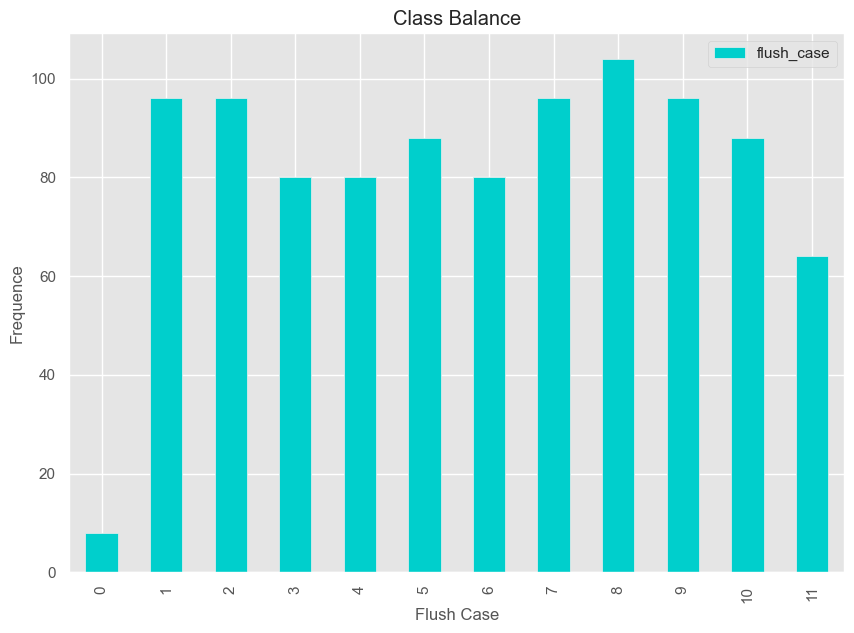

In [131]:
legend = list(np.unique(dt.flush_case))
data = dt['flush_case'].value_counts().reset_index().sort_values(by = 'index')

data.plot.bar(x='index', y='flush_case', color ="#00cfcc") #Unbalanced classes
plt.xlabel('Flush Case')
plt.ylabel('Frequence')
plt.title(r'Class Balance')

## Split features and labels

In [132]:
dt.columns

Index(['id', 'urine', 'paper', 'feces', 'b1p1', 'b1p2', 'g1p1', 'g1p2', 'r1p1',
       'r1p2', 'b2p1', 'b2p2', 'g2p1', 'g2p2', 'r2p1', 'r2p2', 'flush',
       'flush_dis', 'flush_case', 'PCB'],
      dtype='object')

In [133]:
dt.PCB

0       0
1       5
2       5
3       0
4       1
       ..
971     3
972     7
973     9
974     9
975    10
Name: PCB, Length: 976, dtype: int64

In [134]:
features = dt.drop(['id', 'urine', 'paper', 'feces', 'flush','flush_dis', 'flush_case', 'PCB'], axis=1)
y = dt['flush_case'].reset_index(drop=True)

In [135]:
y

0       0
1       4
2       7
3       1
4       1
       ..
971     4
972     8
973     9
974    10
975    11
Name: flush_case, Length: 976, dtype: int64

<AxesSubplot:>

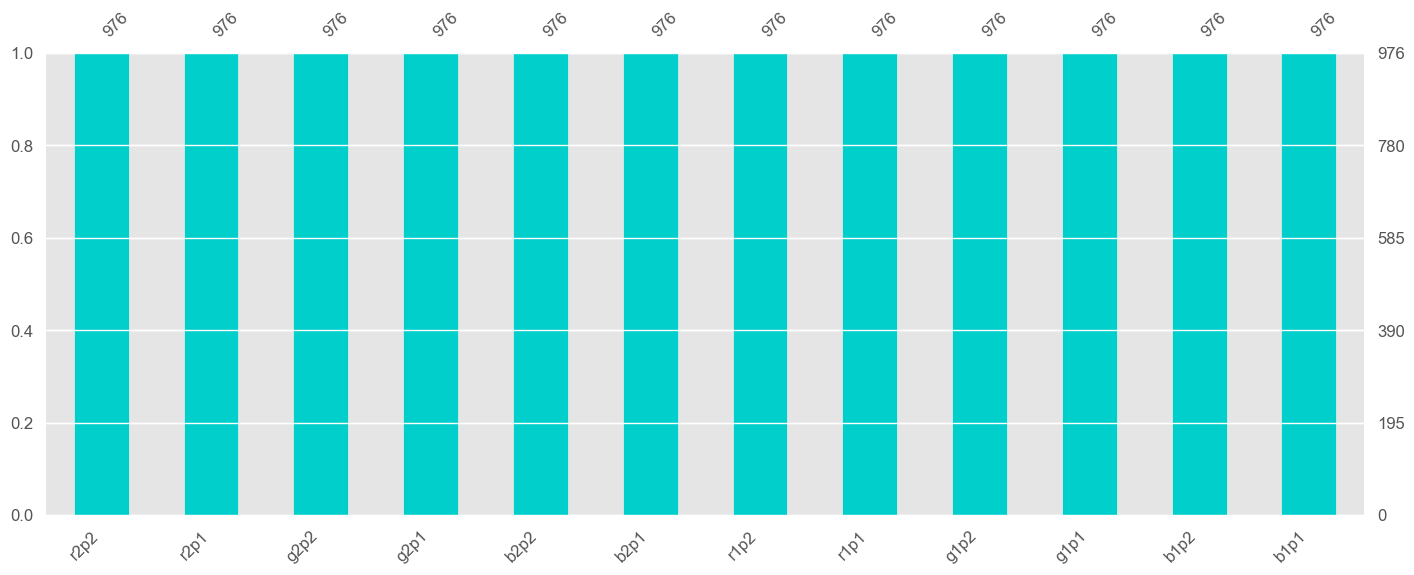

In [136]:
# Bar plot of missing values and percentage
msno.bar(features, labels=True, figsize=(17,6), fontsize=12, sort="descending", color="#00cfcc")

## Univariate analysis

## Outlier detection and treatment

count     976.000000
mean      146.952869
std       188.540189
min         0.000000
25%        31.000000
50%        95.000000
75%       174.000000
max      1244.000000
Name: b1p1, dtype: float64


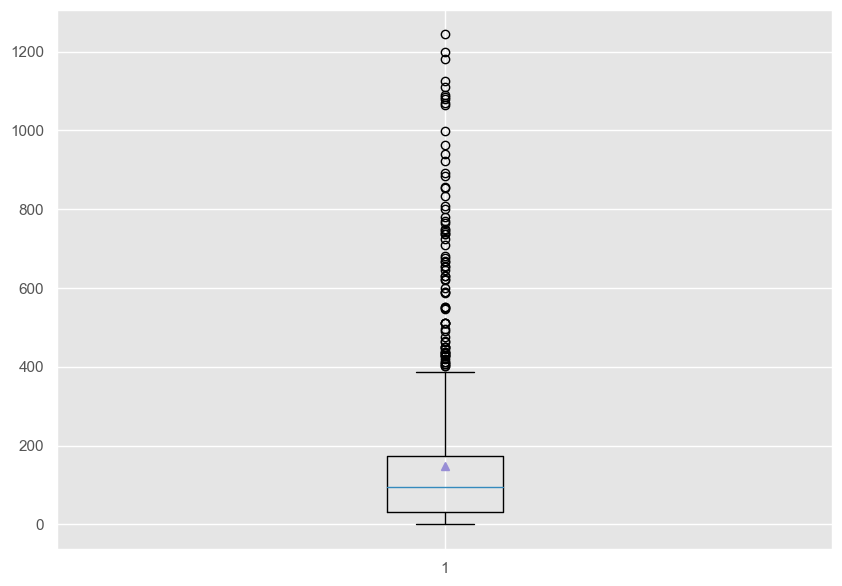

In [137]:
# Check outliers for each desired variable
  
#'b1p1'

variable = 'b1p1' 
print(features[variable].describe())
_ = plt.boxplot(features[variable], showmeans=True)


# Capping - Solution

count     976.000000
mean      181.202869
std       266.804198
min         0.000000
25%         4.000000
50%        60.500000
75%       231.250000
max      1068.000000
Name: b1p2, dtype: float64


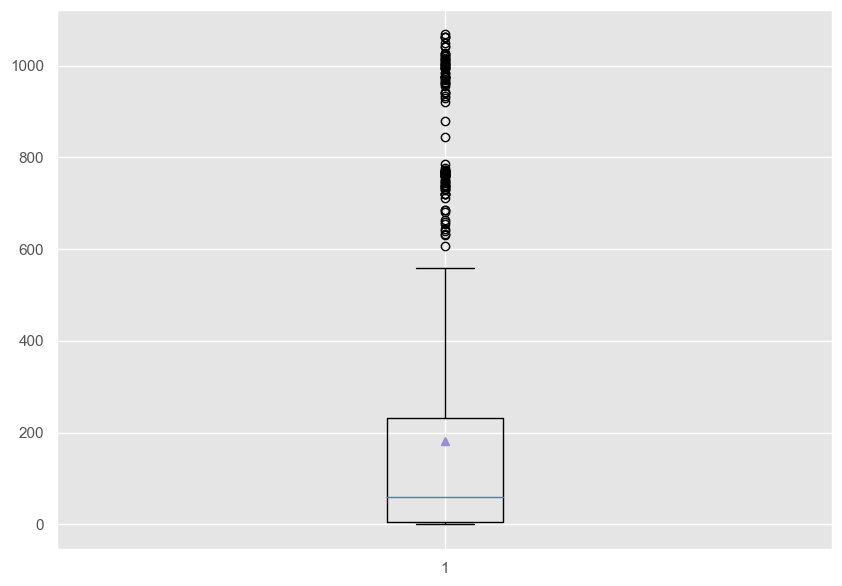

In [138]:
#'b1p2'
    
variable = 'b1p2'
print(features[variable].describe())
_ = plt.boxplot(features[variable], showmeans=True)


count    976.000000
mean     122.055328
std      121.106518
min        0.000000
25%       20.750000
50%       86.500000
75%      190.250000
max      588.000000
Name: g1p1, dtype: float64


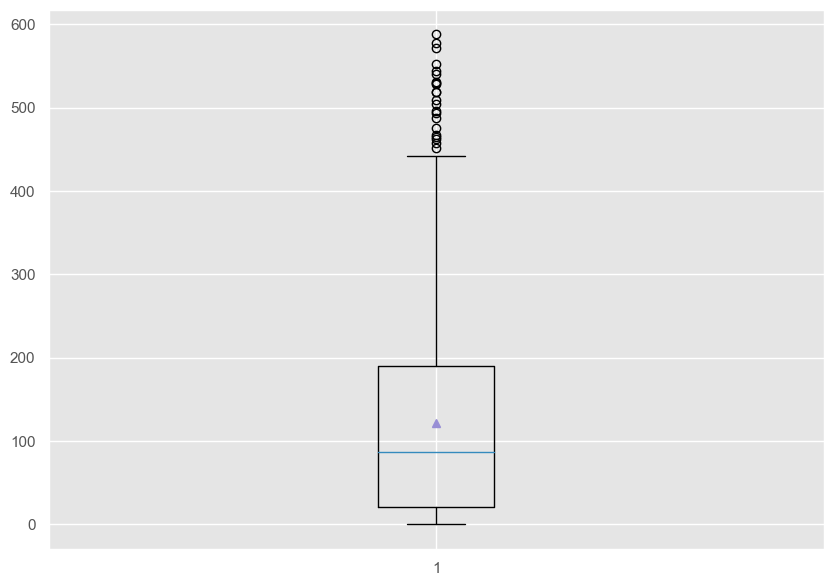

In [139]:
#'g1p1', 
    
variable = 'g1p1'
print(features[variable].describe())
_ = plt.boxplot(features[variable], showmeans=True)

count    976.000000
mean     177.634221
std      157.350539
min        0.000000
25%        4.000000
50%      202.000000
75%      309.000000
max      526.000000
Name: g1p2, dtype: float64


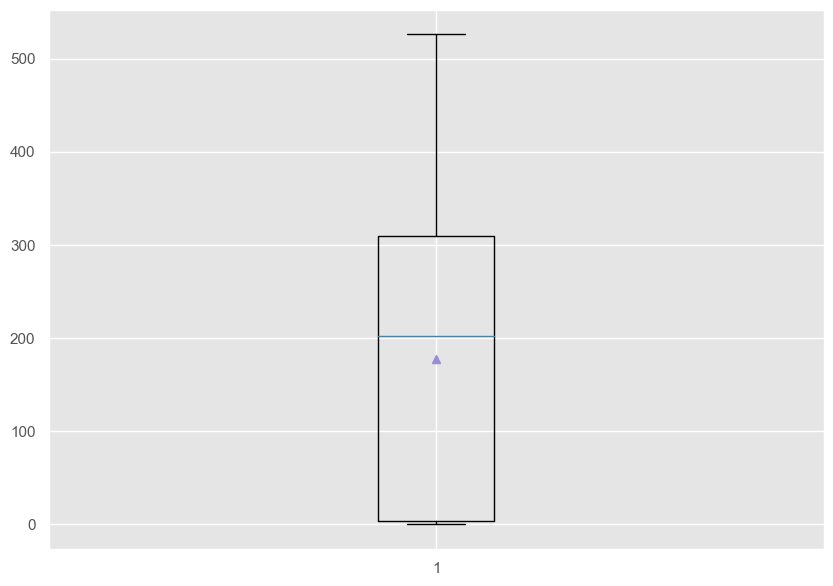

In [140]:
#'g1p2'
    
variable = 'g1p2'
print(features[variable].describe())
_ = plt.boxplot(features[variable], showmeans=True)

count     976.000000
mean      399.449795
std       392.856902
min         0.000000
25%        46.000000
50%       261.500000
75%       652.000000
max      1779.000000
Name: r1p1, dtype: float64


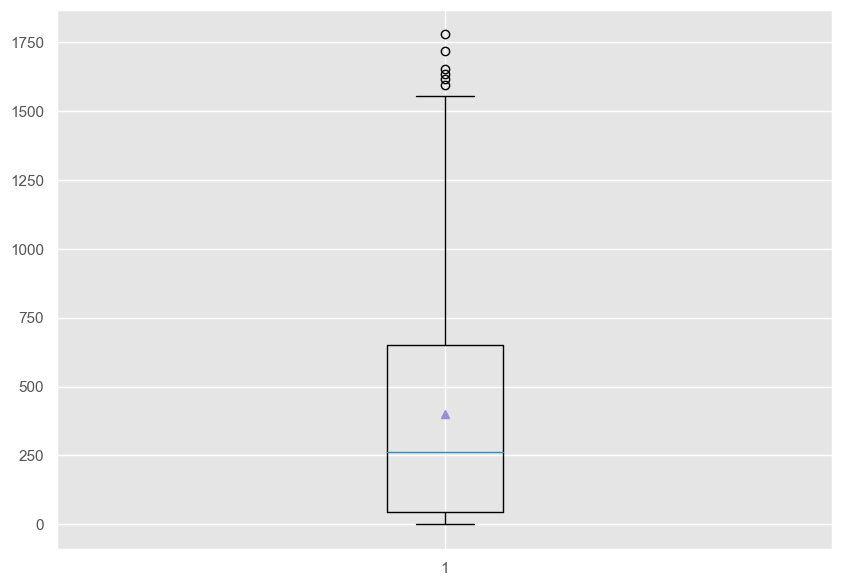

In [141]:
#'r1p1'
    
variable = 'r1p1'
print(features[variable].describe())
_ = plt.boxplot(features[variable], showmeans=True)

count     976.000000
mean      531.206967
std       457.802410
min         0.000000
25%        10.000000
50%       657.000000
75%       857.000000
max      1347.000000
Name: r1p2, dtype: float64


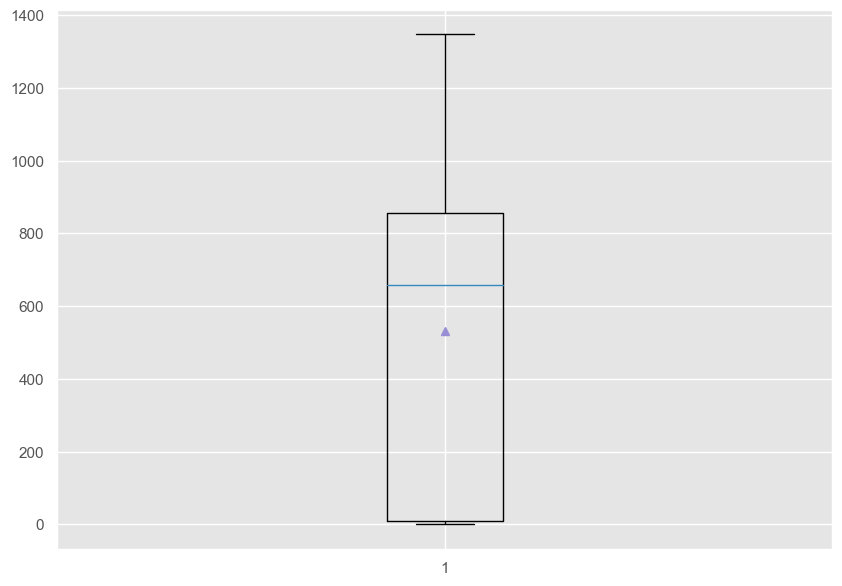

In [142]:
#'r1p2'
    
variable = 'r1p2'
print(features[variable].describe())
_ = plt.boxplot(features[variable], showmeans=True)

count    976.000000
mean      35.274590
std       58.903715
min        0.000000
25%        3.000000
50%       14.500000
75%       37.250000
max      378.000000
Name: b2p1, dtype: float64


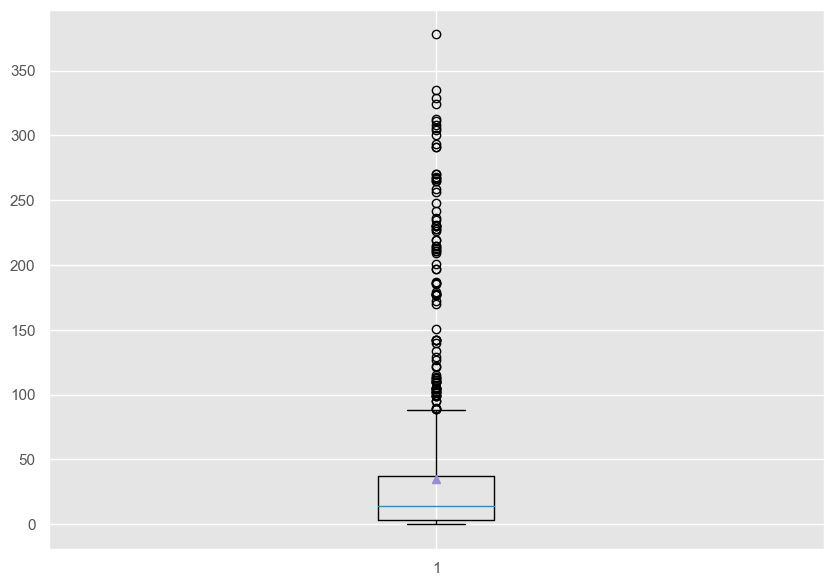

In [143]:
#'b2p1'
    
variable = 'b2p1'
print(features[variable].describe())
_ = plt.boxplot(features[variable], showmeans=True)

count    976.000000
mean      44.640369
std       76.530823
min        0.000000
25%        5.000000
50%       19.000000
75%       45.000000
max      542.000000
Name: b2p2, dtype: float64


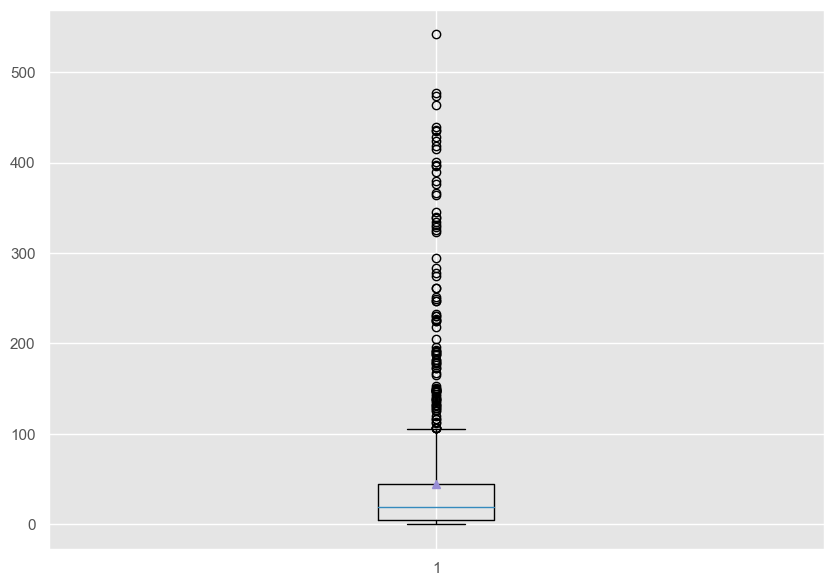

In [144]:
#'b2p2'
    
variable = 'b2p2'
print(features[variable].describe())
_ = plt.boxplot(features[variable], showmeans=True)

count    976.000000
mean      39.376025
std       39.880784
min        0.000000
25%        6.000000
50%       26.000000
75%       64.000000
max      186.000000
Name: g2p1, dtype: float64


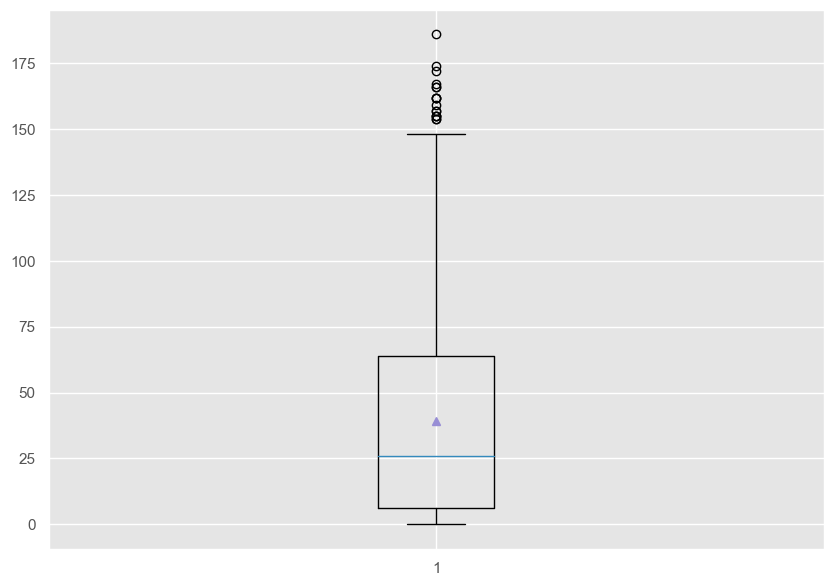

In [145]:
# 'g2p1'
    
variable = 'g2p1'
print(features[variable].describe())
_ = plt.boxplot(features[variable], showmeans=True)

count    976.000000
mean      50.810451
std       54.001215
min        0.000000
25%        7.000000
50%       32.000000
75%       78.000000
max      289.000000
Name: g2p2, dtype: float64


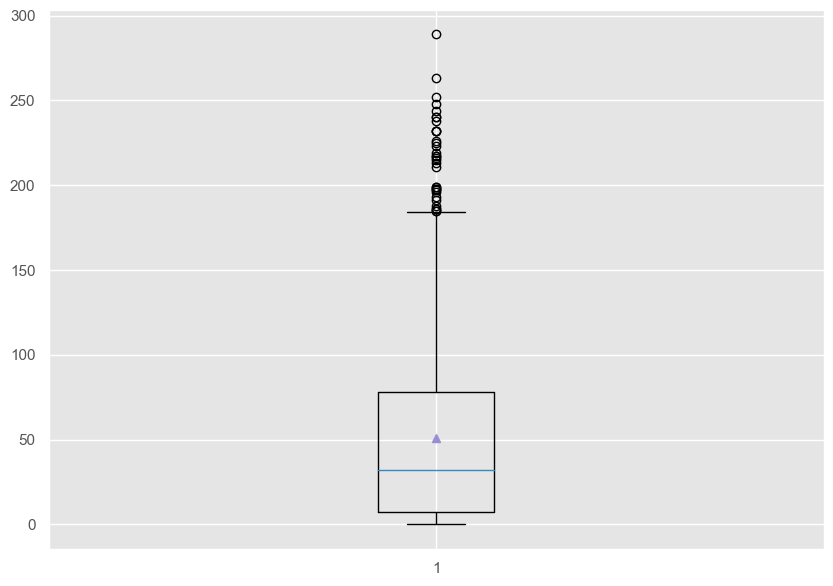

In [146]:
#'g2p2'
    
variable = 'g2p2'
print(features[variable].describe())
_ = plt.boxplot(features[variable], showmeans=True)

count    976.000000
mean     140.097336
std      134.210993
min        0.000000
25%       20.000000
50%       92.500000
75%      254.000000
max      567.000000
Name: r2p1, dtype: float64


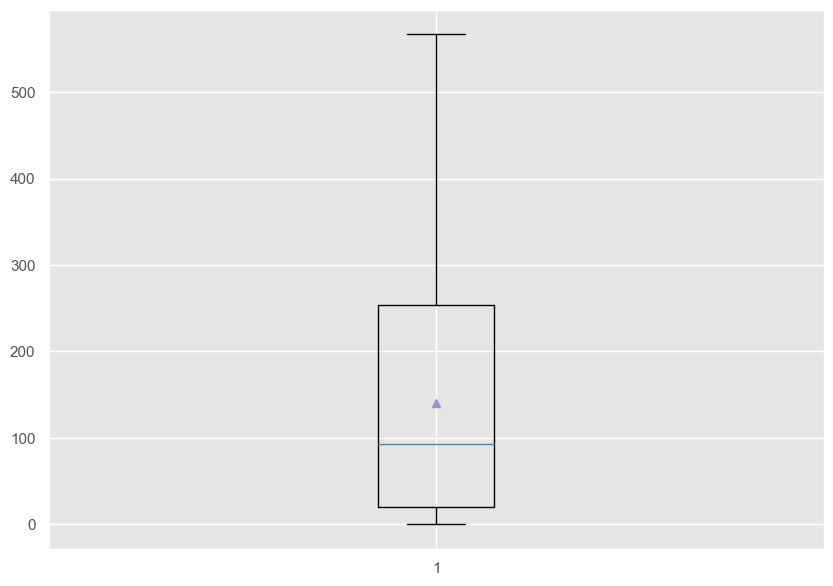

In [147]:
#'r2p1'
    
variable = 'r2p1'
print(features[variable].describe())
_ = plt.boxplot(features[variable], showmeans=True)

count    976.000000
mean     166.474385
std      160.452020
min        0.000000
25%       20.750000
50%      113.000000
75%      292.250000
max      598.000000
Name: r2p2, dtype: float64


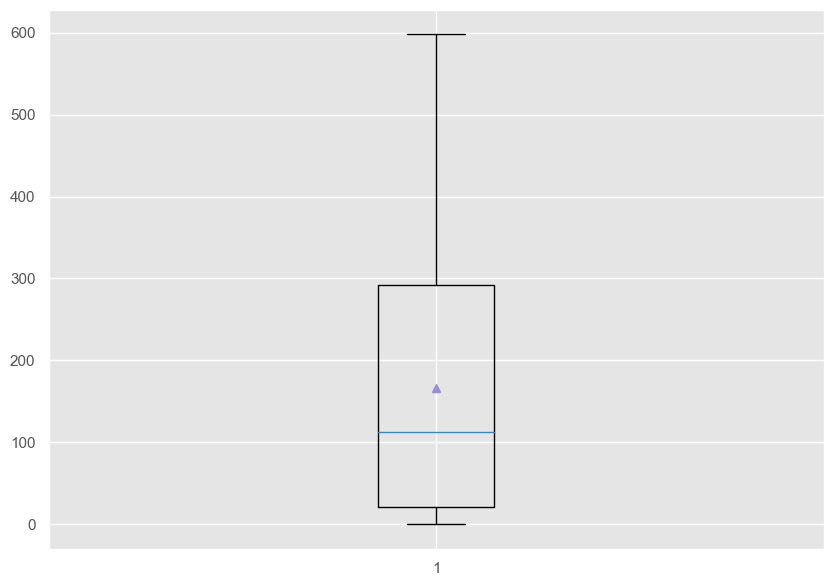

In [148]:
#'r2p2'
    
variable = 'r2p2'
print(features[variable].describe())
_ = plt.boxplot(features[variable], showmeans=True)

## Outlier general visualization

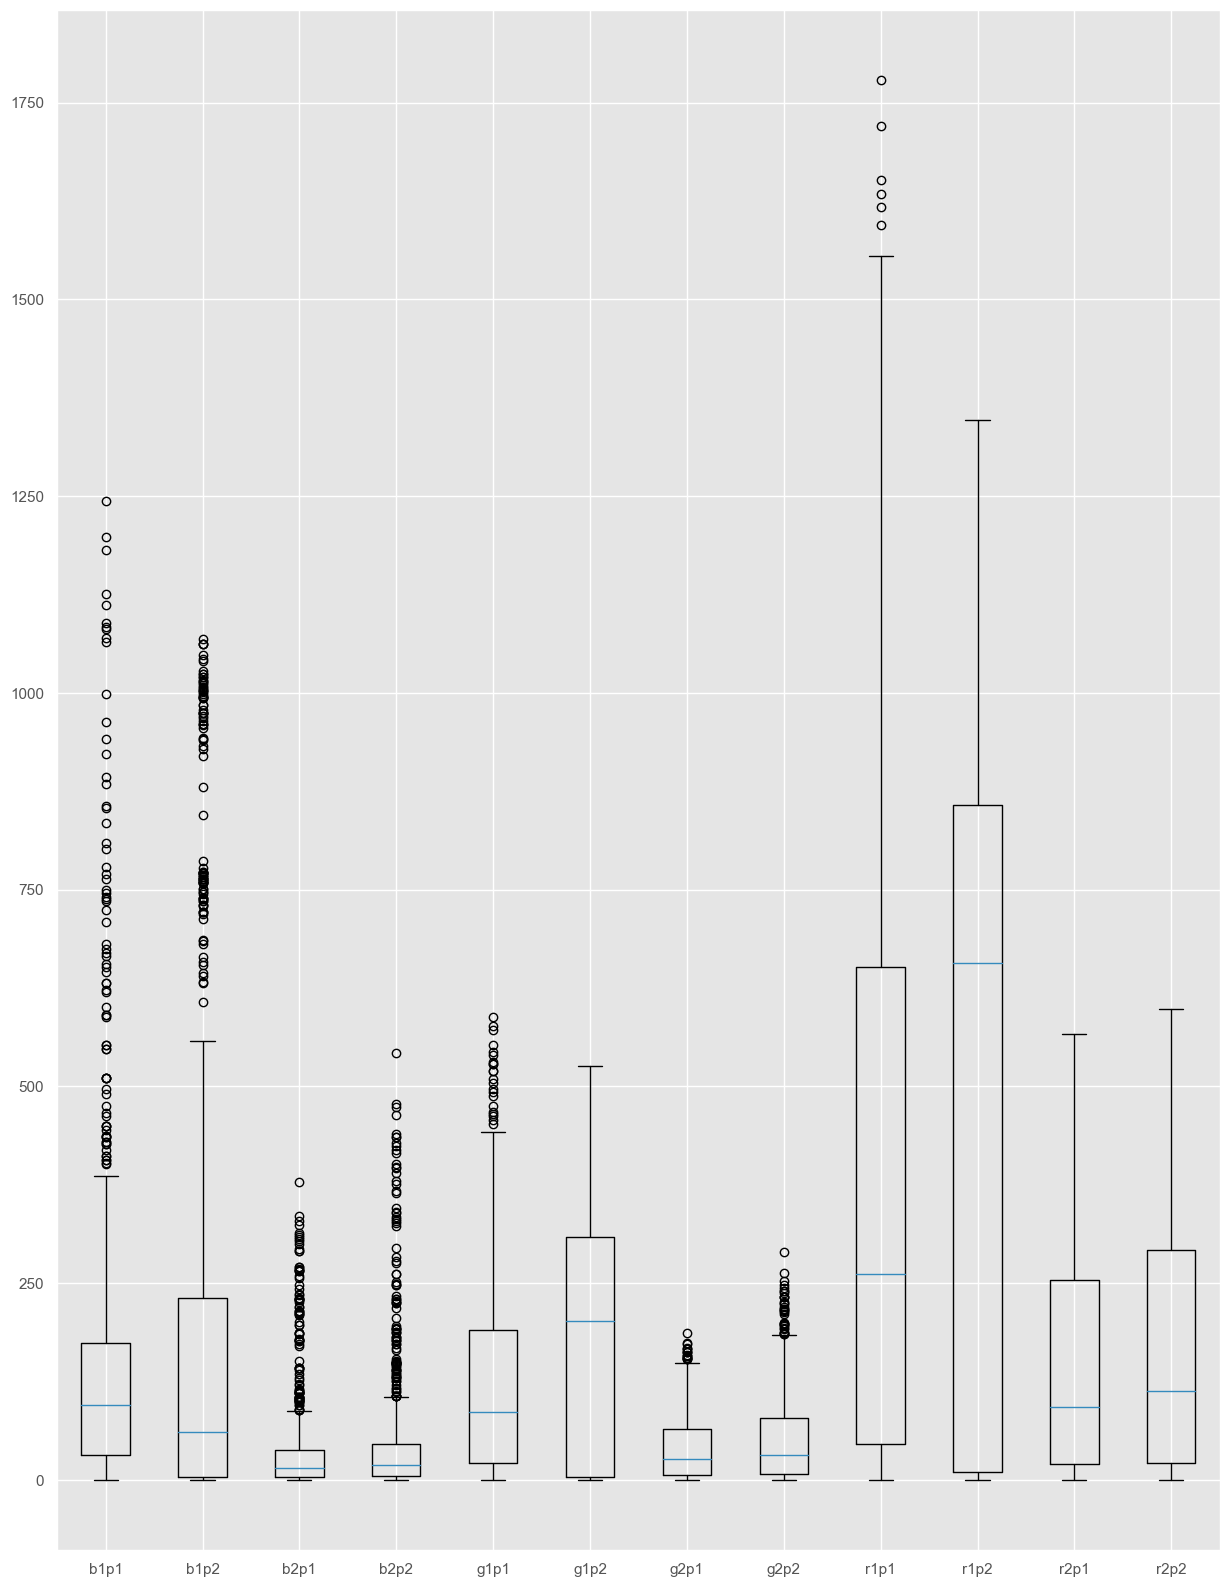

In [149]:
labels = ['b1p1', 'b1p2', 'b2p1', 'b2p2', 'g1p1', 'g1p2', 'g2p1', 'g2p2', 'r1p1', 'r1p2', 'r2p1', 'r2p2']
plt.figure(figsize=(15,20))
bp = plt.boxplot( [features.b1p1, features.b1p2, features.b2p1, features.b2p2, features.g1p1, features.g1p2, features.g2p1, features.g2p2, features.r1p1, features.r1p2, features.r2p1, features.r2p2], labels=labels)
plt.show()

## Understand the outliers

In [150]:
print(get_box_plot_data(labels, bp))

   label  lower_whisker  lower_quartile  median  upper_quartile  upper_whisker
0   b1p1            0.0           31.00    95.0          174.00          386.0
1   b1p2            0.0            4.00    60.5          231.25          558.0
2   b2p1            0.0            3.00    14.5           37.25           88.0
3   b2p2            0.0            5.00    19.0           45.00          105.0
4   g1p1            0.0           20.75    86.5          190.25          442.0
5   g1p2            0.0            4.00   202.0          309.00          526.0
6   g2p1            0.0            6.00    26.0           64.00          148.0
7   g2p2            0.0            7.00    32.0           78.00          184.0
8   r1p1            0.0           46.00   261.5          652.00         1555.0
9   r1p2            0.0           10.00   657.0          857.00         1347.0
10  r2p1            0.0           20.00    92.5          254.00          567.0
11  r2p2            0.0           20.75   113.0     

In [151]:
# Transforming the data lower than upper_whisker as NaN in dt_outliers
dt_outliers=dt.drop(['flush','flush_dis', 'PCB', 'g1p2', 'r1p2','r2p1', 'r2p2'], axis=1)
dt_outliers["b1p1"]= dt_outliers["b1p1"].where(dt_outliers["b1p1"]>386, float("NaN"))
dt_outliers["b1p2"]= dt_outliers["b1p2"].where(dt_outliers["b1p2"]>558, float("NaN"))
dt_outliers["b2p1"]= dt_outliers["b2p1"].where(dt_outliers["b2p1"]>89, float("NaN"))
dt_outliers["b2p2"]= dt_outliers["b2p2"].where(dt_outliers["b2p2"]>105, float("NaN"))
dt_outliers["g1p1"]= dt_outliers["g1p1"].where(dt_outliers["g1p1"]>465, float("NaN"))

dt_outliers["g2p1"]= dt_outliers["g2p1"].where(dt_outliers["g2p1"]>148, float("NaN"))
dt_outliers["g2p2"]= dt_outliers["g2p2"].where(dt_outliers["g2p2"]>184, float("NaN"))
dt_outliers["r1p1"]= dt_outliers["r1p1"].where(dt_outliers["r1p1"]>1652, float("NaN"))
print(dt_outliers)

          id  urine  paper  feces   b1p1    b1p2  g1p1  r1p1   b2p1   b2p2  \
0        n°1      0      0      0  548.0   995.0   NaN   NaN  259.0  376.0   
1        n°2      0      0      1    NaN   975.0   NaN   NaN  134.0  129.0   
2        n°3      0      0      2    NaN   955.0   NaN   NaN    NaN  117.0   
3        n°6      0      1      0  652.0  1002.0   NaN   NaN  242.0  329.0   
4    n°6 bis      0      1      0  736.0  1068.0   NaN   NaN  215.0  346.0   
..       ...    ...    ...    ...    ...     ...   ...   ...    ...    ...   
971    n°121      4      4      0    NaN     NaN   NaN   NaN    NaN    NaN   
972    n°122      4      4      1    NaN     NaN   NaN   NaN    NaN    NaN   
973    n°123      4      4      2    NaN     NaN   NaN   NaN    NaN    NaN   
974    n°124      4      4      3    NaN     NaN   NaN   NaN    NaN    NaN   
975    n°125      4      4      4    NaN     NaN   NaN   NaN    NaN    NaN   

     g2p1   g2p2  flush_case  
0     NaN  188.0           0  
1

## Error estimators (Only activate when want to work with error estimator)

In [152]:
X=dt[['b2p1']]
X = sm.add_constant(X)
Y=dt[["b1p1"]]
model = sm.OLS(Y, X)
results = model.fit()
res_b1p1=results.resid

X=dt[['r1p1']]
X = sm.add_constant(X)
Y=dt[["g1p1"]]
model = sm.OLS(Y, X)
results = model.fit()
res_g1p1=results.resid

X=dt[['r1p2']]
X = sm.add_constant(X)
Y=dt[["g1p2"]]
model = sm.OLS(Y, X)
results = model.fit()
res_g1p2=results.resid

X=dt[['r2p1']]
X = sm.add_constant(X)
Y=dt[["r1p1"]]
model = sm.OLS(Y, X)
results = model.fit()
res_r1p1=results.resid

X=dt[['b2p2']]
X = sm.add_constant(X)
Y=dt[["b2p1"]]
model = sm.OLS(Y, X)
results = model.fit()
res_b2p1=results.resid

X=dt[['g2p2','r2p1','r2p2']]
X = sm.add_constant(X)
Y=dt[["g2p1"]]
model = sm.OLS(Y, X)
results = model.fit()
res_g2p1=results.resid

X=dt[['r2p2']]
X = sm.add_constant(X)
Y=dt[["g2p2"]]
model = sm.OLS(Y, X)
results = model.fit()
res_g2p2=results.resid

X=dt[['r2p2']]
X = sm.add_constant(X)
Y=dt[["r2p1"]]
model = sm.OLS(Y, X)
results = model.fit()
res_r2p1=results.resid


res=pd.DataFrame()
res["res_b1p1"]=res_b1p1+abs(res_b1p1.min())
res["res_g1p1"]=res_g1p1+abs(res_g1p1.min())
res["res_g1p2"]=res_g1p2+abs(res_g1p2.min())
res["res_r1p1"]=res_r1p1+abs(res_r1p1.min())
res["res_b2p1"]=res_b2p1+abs(res_b2p1.min())
res["res_g2p1"]=res_g2p1+abs(res_g2p1.min())
res["res_g2p2"]=res_g2p2+abs(res_g2p2.min())
res["res_r2p1"]=res_r2p1+abs(res_r2p1.min())

res["b1p2"]=dt.b1p2
res["b2p2"]=dt.b2p2
res["r1p2"]=dt.r1p2
res["r2p2"]=dt.r2p2

features=res
print(features)

       res_b1p1    res_g1p1    res_g1p2    res_r1p1    res_b2p1   res_g2p1  \
0    243.203284  196.954765  181.689724  340.870530  100.122229  29.720207   
1    352.148189  169.205406  178.335178  455.328682  154.379277  30.866824   
2    318.683946  149.042095  176.313043  395.166010  108.088122  25.070375   
3    394.659791  206.182932  181.698024  556.654026  117.231870  30.427762   
4    554.031890  215.630996  189.418184  734.038899   77.894341  26.985351   
..          ...         ...         ...         ...         ...        ...   
971  516.509974  103.411613  118.202757  789.524556  115.564773  23.674637   
972  500.884652  136.243910  132.438328  776.226717  117.644933  22.241595   
973  430.050889  138.645712  129.893256  494.266795  115.822144  23.340155   
974  419.217126  137.464832  122.175476  535.246166  113.273618  26.328766   
975  423.217126  128.292224  129.577447  628.178583  113.999355  26.192051   

       res_g2p2    res_r2p1  b1p2  b2p2  r1p2  r2p2  
0    107.

## Outlier treatment (Only uncomment when trying to work with cap)

In [153]:
# Define variables to cap and floor
#vars_cap = features.columns

# Cap and floor variables selected 
#features = treatoutliers(df = features, columns = vars_cap, method = 'PCT', treament = 'cap', pct_min = 0.05, pct_max = 0.95)

In [154]:
# Execute univariate analysis (mainly or quantivative variables)
our_summary = full_describe(dataframe = features , variability = 20 , completeness = 10)
# Export summary to excel fileon the actual local machine to review
path = os.getcwd()
our_summary.to_excel(path + '/resumen_variables.xlsx', sheet_name = 'resumen')
#We can use all variables high variability 

Describe process started, Time: 15:09:24
Describe function calculatation finished. Elapsed Time: 0 segs
Inicia calculo de completeness and variability, Time: 15:09:24
Completeness and variability calculation finished. Elapsed time: 0 segs
Whole process completed. Total Elapsed time: 0 segs


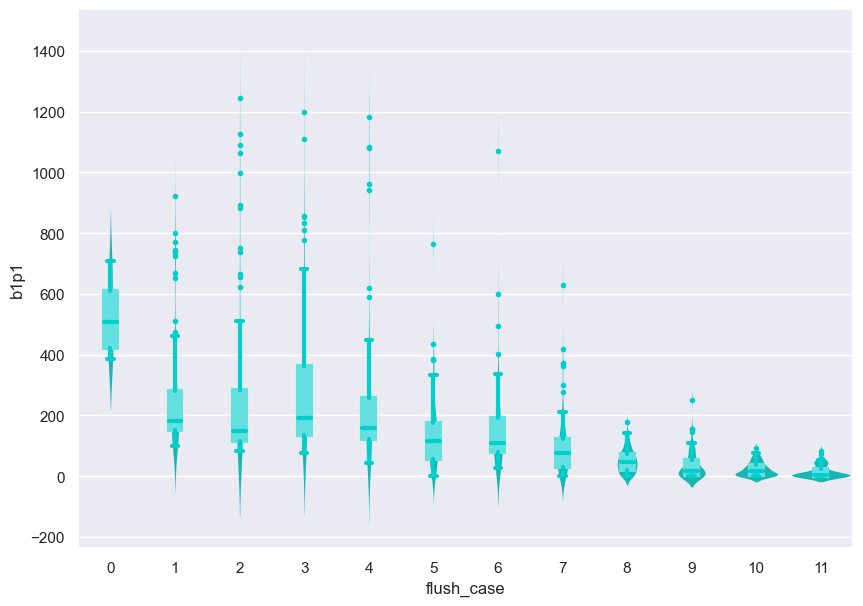

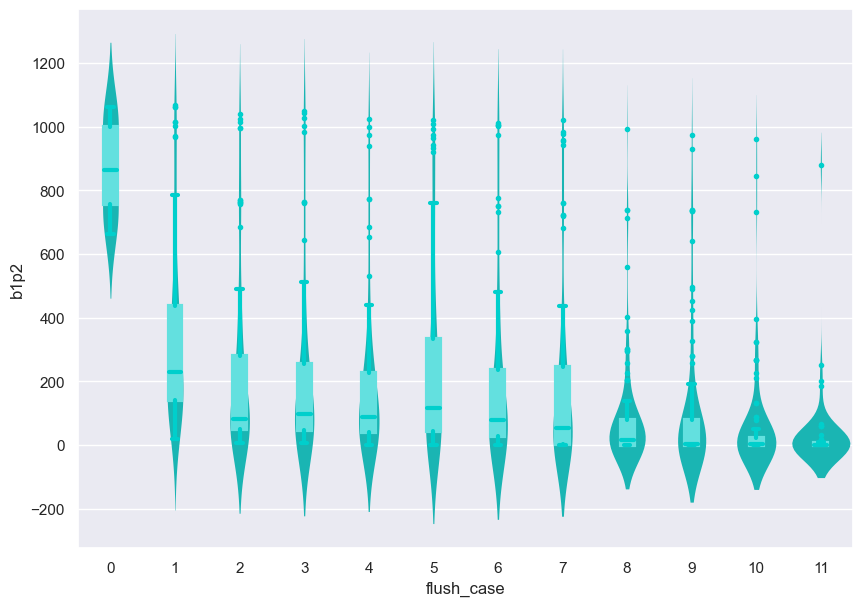

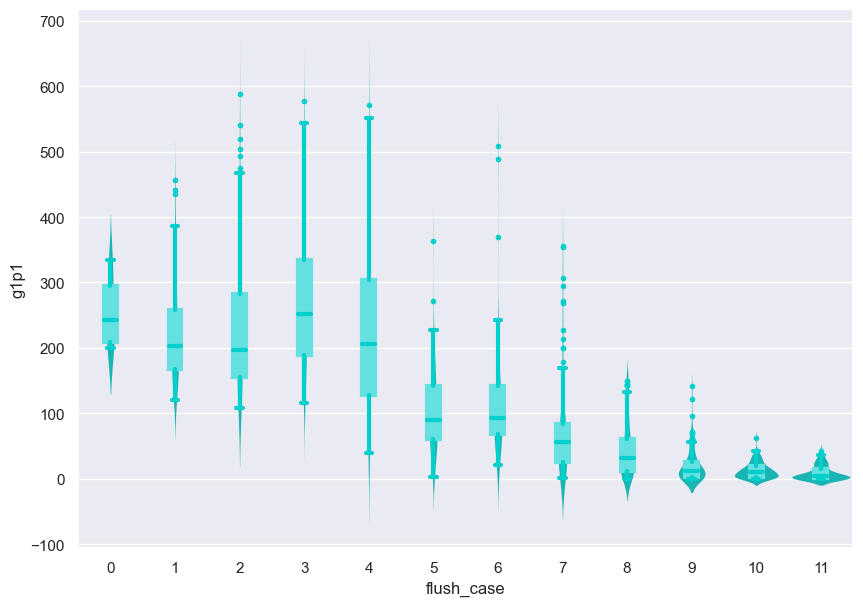

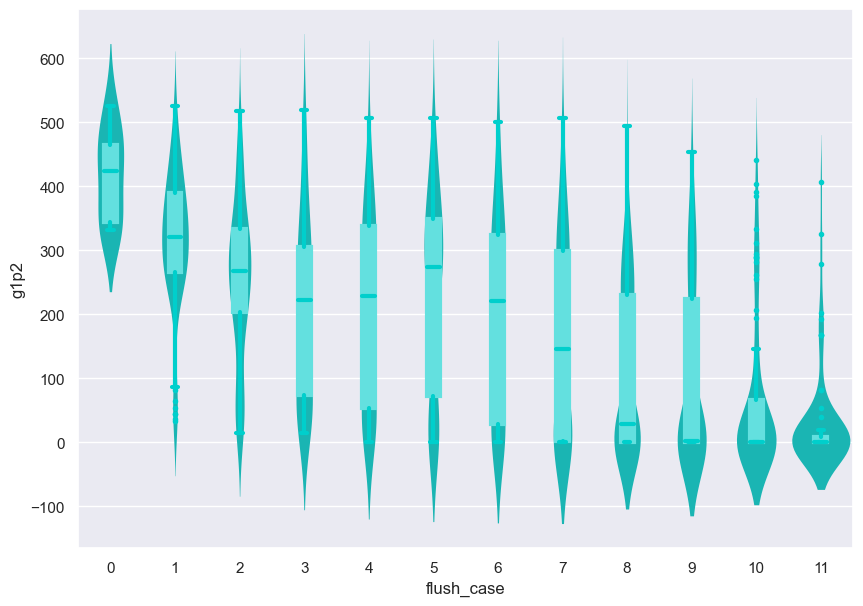

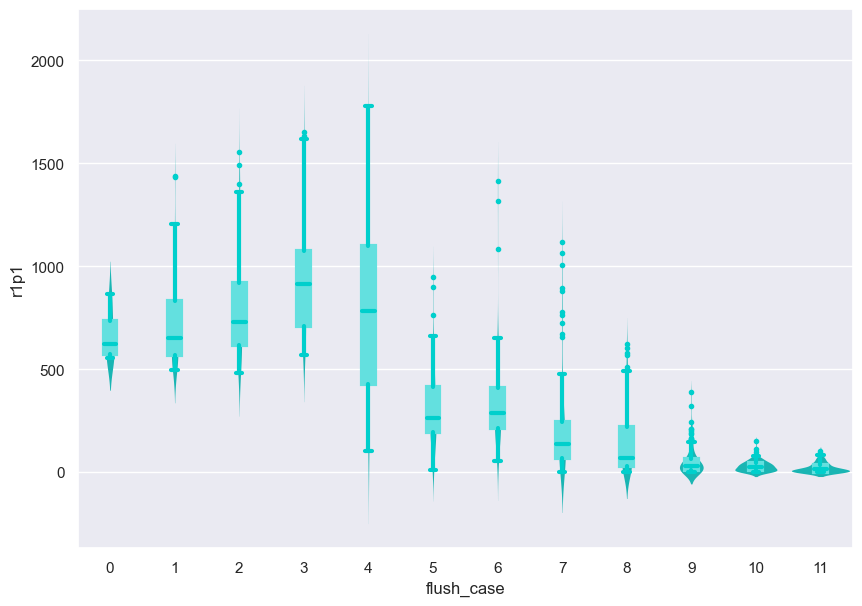

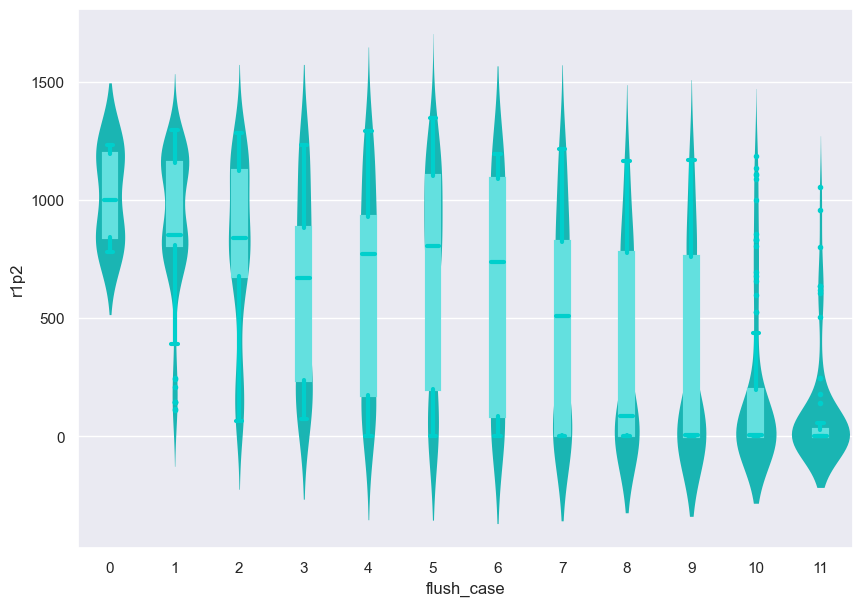

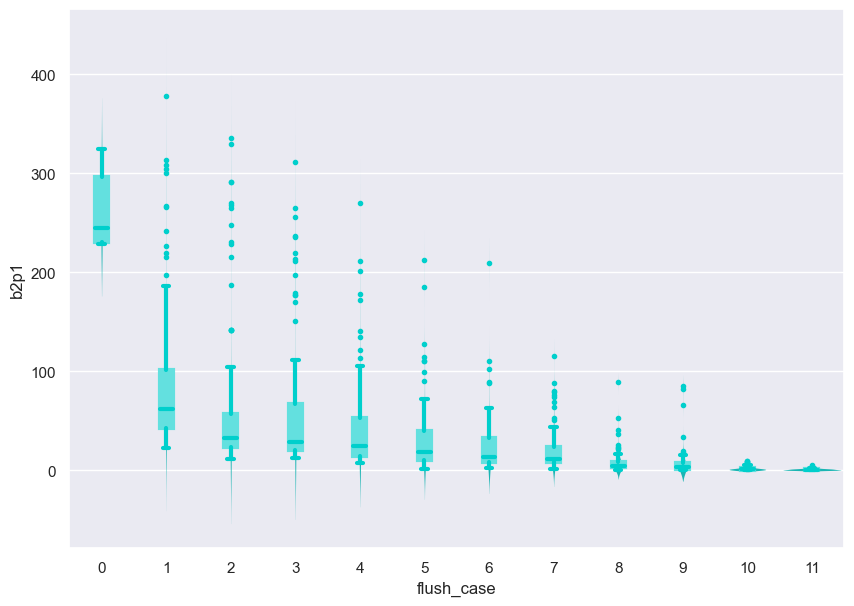

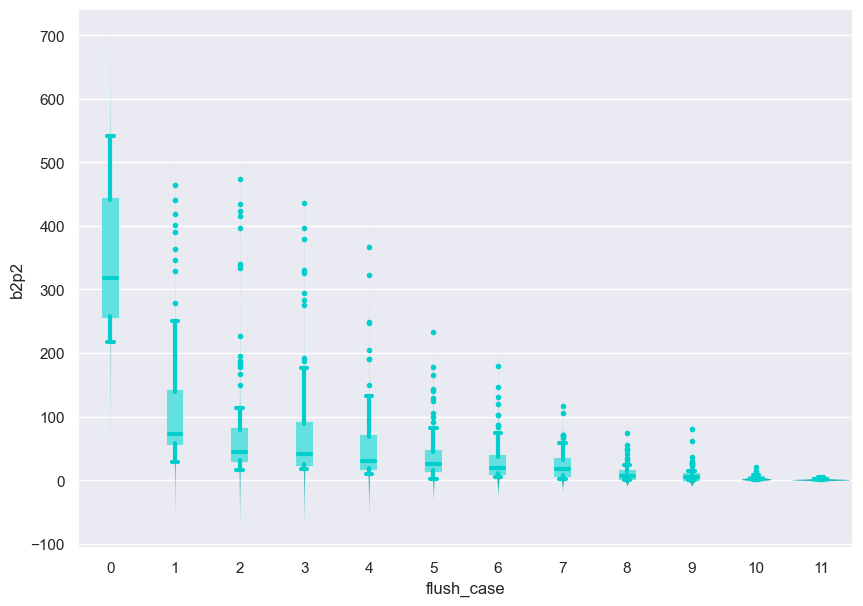

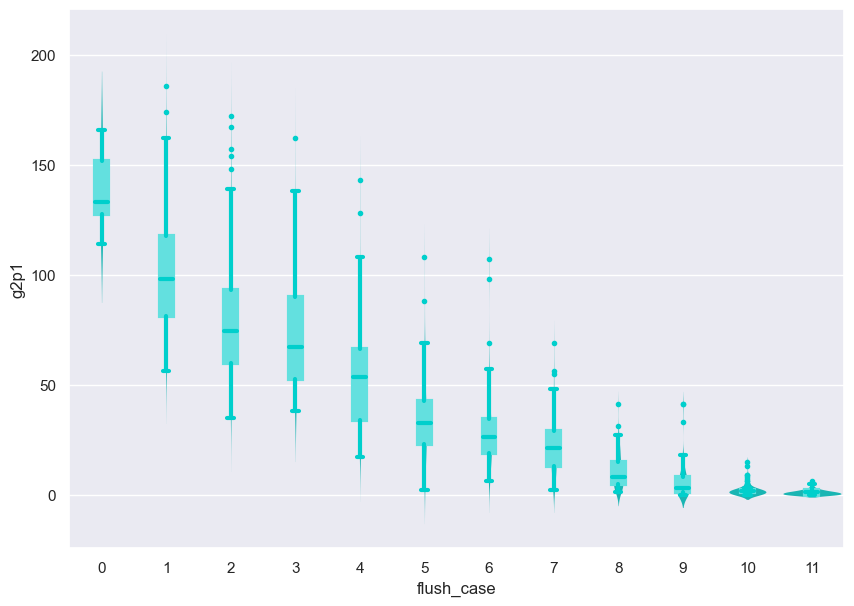

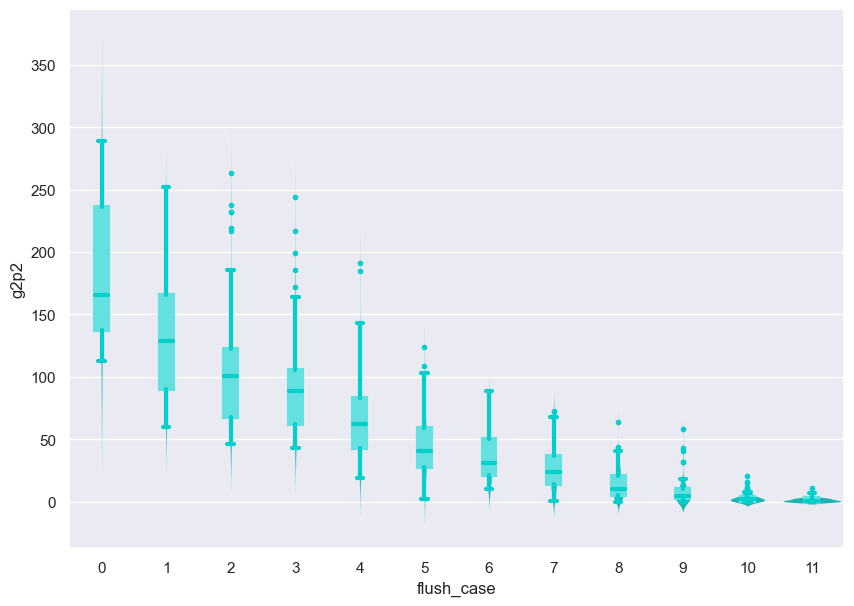

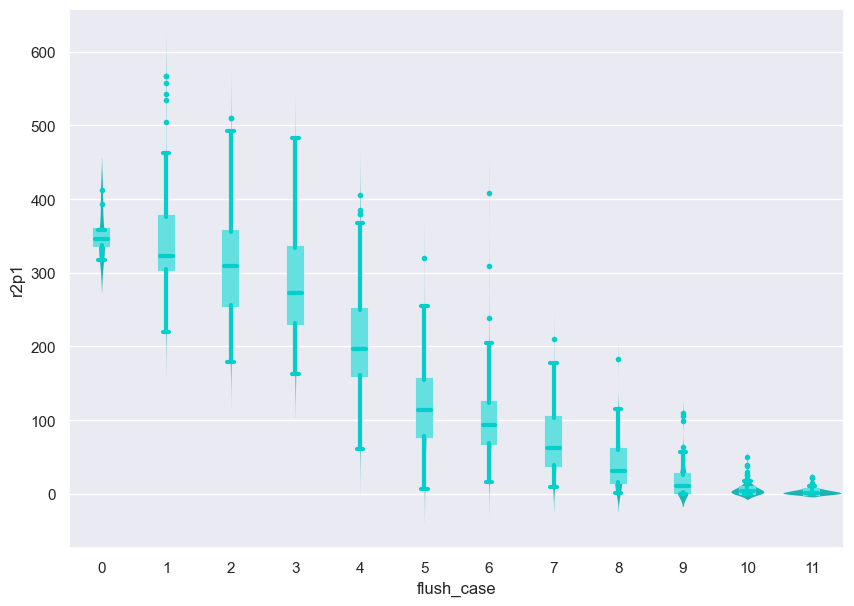

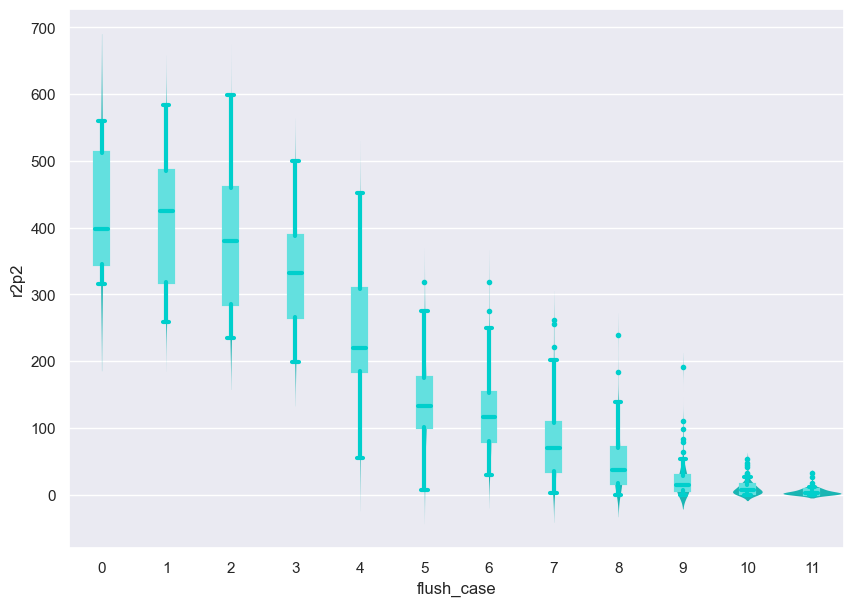

In [155]:
#We analyze every variable

#/////For b1p1
sns.set(style="darkgrid", rc = {'figure.figsize':(10,7)})
ax = sns.violinplot(data=dt, x = 'flush_case', y='b1p1', color="#00cfcc", inner=None, linewidth=0, width=0.9)
# ax.set_edgecolor('black')
haha = sns.boxplot(data=dt, x = 'flush_case', y='b1p1', width=0.2
    ,medianprops={'color':'#00cfcc', 'linewidth':3}
    ,boxprops = dict(zorder= 1, linewidth=3, color='#63e0df'),       
    whiskerprops = dict(color='#00cfcc', linewidth=3),
    capprops = dict(color='#00cfcc', linewidth=3)
    ,flierprops = dict(marker='o', markersize=3,  markerfacecolor='#00cfcc', markeredgecolor='#00cfcc')
    , ax=ax)

plt.show()

#/////For b1p2

sns.set(style="darkgrid", rc = {'figure.figsize':(10,7)})
ax = sns.violinplot(data=dt, x = 'flush_case', y='b1p2', color="#00cfcc", inner=None, linewidth=0, width=0.9)
# ax.set_edgecolor('black')
haha = sns.boxplot(data=dt, x = 'flush_case', y='b1p2', width=0.2
    ,medianprops={'color':'#00cfcc', 'linewidth':3}
    ,boxprops = dict(zorder= 1, linewidth=3, color='#63e0df'),       
    whiskerprops = dict(color='#00cfcc', linewidth=3),
    capprops = dict(color='#00cfcc', linewidth=3)
    ,flierprops = dict(marker='o', markersize=3,  markerfacecolor='#00cfcc', markeredgecolor='#00cfcc')
    , ax=ax)

plt.show()

#/////For g1p1

sns.set(style="darkgrid", rc = {'figure.figsize':(10,7)})
ax = sns.violinplot(data=dt, x = 'flush_case', y='g1p1', color="#00cfcc", inner=None, linewidth=0, width=0.9)
# ax.set_edgecolor('black')
haha = sns.boxplot(data=dt, x = 'flush_case', y='g1p1', width=0.2
    ,medianprops={'color':'#00cfcc', 'linewidth':3}
    ,boxprops = dict(zorder= 1, linewidth=3, color='#63e0df'),       
    whiskerprops = dict(color='#00cfcc', linewidth=3),
    capprops = dict(color='#00cfcc', linewidth=3)
    ,flierprops = dict(marker='o', markersize=3,  markerfacecolor='#00cfcc', markeredgecolor='#00cfcc')
    , ax=ax)

plt.show()


#/////For g1p2

sns.set(style="darkgrid", rc = {'figure.figsize':(10,7)})
ax = sns.violinplot(data=dt, x = 'flush_case', y='g1p2', color="#00cfcc", inner=None, linewidth=0, width=0.9)
# ax.set_edgecolor('black')
haha = sns.boxplot(data=dt, x = 'flush_case', y='g1p2', width=0.2
    ,medianprops={'color':'#00cfcc', 'linewidth':3}
    ,boxprops = dict(zorder= 1, linewidth=3, color='#63e0df'),       
    whiskerprops = dict(color='#00cfcc', linewidth=3),
    capprops = dict(color='#00cfcc', linewidth=3)
    ,flierprops = dict(marker='o', markersize=3,  markerfacecolor='#00cfcc', markeredgecolor='#00cfcc')
    , ax=ax)

plt.show()

#/////For r1p1

sns.set(style="darkgrid", rc = {'figure.figsize':(10,7)})
ax = sns.violinplot(data=dt, x = 'flush_case', y='r1p1', color="#00cfcc", inner=None, linewidth=0, width=0.9)
# ax.set_edgecolor('black')
haha = sns.boxplot(data=dt, x = 'flush_case', y='r1p1', width=0.2
    ,medianprops={'color':'#00cfcc', 'linewidth':3}
    ,boxprops = dict(zorder= 1, linewidth=3, color='#63e0df'),       
    whiskerprops = dict(color='#00cfcc', linewidth=3),
    capprops = dict(color='#00cfcc', linewidth=3)
    ,flierprops = dict(marker='o', markersize=3,  markerfacecolor='#00cfcc', markeredgecolor='#00cfcc')
    , ax=ax)

plt.show()

#/////For r1p2

sns.set(style="darkgrid", rc = {'figure.figsize':(10,7)})
ax = sns.violinplot(data=dt, x = 'flush_case', y='r1p2', color="#00cfcc", inner=None, linewidth=0, width=0.9)
# ax.set_edgecolor('black')
haha = sns.boxplot(data=dt, x = 'flush_case', y='r1p2', width=0.2
    ,medianprops={'color':'#00cfcc', 'linewidth':3}
    ,boxprops = dict(zorder= 1, linewidth=3, color='#63e0df'),       
    whiskerprops = dict(color='#00cfcc', linewidth=3),
    capprops = dict(color='#00cfcc', linewidth=3)
    ,flierprops = dict(marker='o', markersize=3,  markerfacecolor='#00cfcc', markeredgecolor='#00cfcc')
    , ax=ax)

plt.show()

#/////For b2p1
sns.set(style="darkgrid", rc = {'figure.figsize':(10,7)})
ax = sns.violinplot(data=dt, x = 'flush_case', y='b2p1', color="#00cfcc", inner=None, linewidth=0, width=0.9)
# ax.set_edgecolor('black')
haha = sns.boxplot(data=dt, x = 'flush_case', y='b2p1', width=0.2
    ,medianprops={'color':'#00cfcc', 'linewidth':3}
    ,boxprops = dict(zorder= 1, linewidth=3, color='#63e0df'),       
    whiskerprops = dict(color='#00cfcc', linewidth=3),
    capprops = dict(color='#00cfcc', linewidth=3)
    ,flierprops = dict(marker='o', markersize=3,  markerfacecolor='#00cfcc', markeredgecolor='#00cfcc')
    , ax=ax)

plt.show()

#/////For b2p2

sns.set(style="darkgrid", rc = {'figure.figsize':(10,7)})
ax = sns.violinplot(data=dt, x = 'flush_case', y='b2p2', color="#00cfcc", inner=None, linewidth=0, width=0.9)
# ax.set_edgecolor('black')
haha = sns.boxplot(data=dt, x = 'flush_case', y='b2p2', width=0.2
    ,medianprops={'color':'#00cfcc', 'linewidth':3}
    ,boxprops = dict(zorder= 1, linewidth=3, color='#63e0df'),       
    whiskerprops = dict(color='#00cfcc', linewidth=3),
    capprops = dict(color='#00cfcc', linewidth=3)
    ,flierprops = dict(marker='o', markersize=3,  markerfacecolor='#00cfcc', markeredgecolor='#00cfcc')
    , ax=ax)

plt.show()

#/////For g2p1

sns.set(style="darkgrid", rc = {'figure.figsize':(10,7)})
ax = sns.violinplot(data=dt, x = 'flush_case', y='g2p1', color="#00cfcc", inner=None, linewidth=0, width=0.9)
# ax.set_edgecolor('black')
haha = sns.boxplot(data=dt, x = 'flush_case', y='g2p1', width=0.2
    ,medianprops={'color':'#00cfcc', 'linewidth':3}
    ,boxprops = dict(zorder= 1, linewidth=3, color='#63e0df'),       
    whiskerprops = dict(color='#00cfcc', linewidth=3),
    capprops = dict(color='#00cfcc', linewidth=3)
    ,flierprops = dict(marker='o', markersize=3,  markerfacecolor='#00cfcc', markeredgecolor='#00cfcc')
    , ax=ax)

plt.show()


#/////For g2p2

sns.set(style="darkgrid", rc = {'figure.figsize':(10,7)})
ax = sns.violinplot(data=dt, x = 'flush_case', y='g2p2', color="#00cfcc", inner=None, linewidth=0, width=0.9)
# ax.set_edgecolor('black')
haha = sns.boxplot(data=dt, x = 'flush_case', y='g2p2', width=0.2
    ,medianprops={'color':'#00cfcc', 'linewidth':3}
    ,boxprops = dict(zorder= 1, linewidth=3, color='#63e0df'),       
    whiskerprops = dict(color='#00cfcc', linewidth=3),
    capprops = dict(color='#00cfcc', linewidth=3)
    ,flierprops = dict(marker='o', markersize=3,  markerfacecolor='#00cfcc', markeredgecolor='#00cfcc')
    , ax=ax)

plt.show()

#/////For r2p1

sns.set(style="darkgrid", rc = {'figure.figsize':(10,7)})
ax = sns.violinplot(data=dt, x = 'flush_case', y='r2p1', color="#00cfcc", inner=None, linewidth=0, width=0.9)
# ax.set_edgecolor('black')
haha = sns.boxplot(data=dt, x = 'flush_case', y='r2p1', width=0.2
    ,medianprops={'color':'#00cfcc', 'linewidth':3}
    ,boxprops = dict(zorder= 1, linewidth=3, color='#63e0df'),       
    whiskerprops = dict(color='#00cfcc', linewidth=3),
    capprops = dict(color='#00cfcc', linewidth=3)
    ,flierprops = dict(marker='o', markersize=3,  markerfacecolor='#00cfcc', markeredgecolor='#00cfcc')
    , ax=ax)

plt.show()

#/////For r2p2

sns.set(style="darkgrid", rc = {'figure.figsize':(10,7)})
ax = sns.violinplot(data=dt, x = 'flush_case', y='r2p2', color="#00cfcc", inner=None, linewidth=0, width=0.9)
# ax.set_edgecolor('black')
haha = sns.boxplot(data=dt, x = 'flush_case', y='r2p2', width=0.2
    ,medianprops={'color':'#00cfcc', 'linewidth':3}
    ,boxprops = dict(zorder= 1, linewidth=3, color='#63e0df'),       
    whiskerprops = dict(color='#00cfcc', linewidth=3),
    capprops = dict(color='#00cfcc', linewidth=3)
    ,flierprops = dict(marker='o', markersize=3,  markerfacecolor='#00cfcc', markeredgecolor='#00cfcc')
    , ax=ax)

plt.show()

In [156]:
# List with all categoricals Variables
lista_variables = list(features.columns)

df_X = []
corr_vars_cat = pd.DataFrame(columns=['variable','fvalue','pvalue','-log_pvalue'])
# we iterate over each variable
for variable in tqdm(lista_variables):
    # We need to clear the list for each iteration.
    df_X.clear()   
    # then, for each variable, we iterate over each one of its category
    for categoria in list(set(features[variable].values)):
        res = pd.concat([features, y],axis=1).loc[features[variable] == categoria]['flush_case']
        df_X.append(res)

    fvalue, pvalue = stats.kruskal(*df_X, nan_policy = 'omit')
    
    row_to_append = pd.DataFrame({'variable': [variable], 'fvalue': [fvalue], 'pvalue': [pvalue], '-log_pvalue': [-np.log(pvalue)]})
    corr_vars_cat = pd.concat([corr_vars_cat, row_to_append], axis=0)
    # print("===============================================================================================================")
    # print("test: F-value",fvalue,"P-value", pvalue,"-log(P-value)",-np.log(pvalue))
    #print("VAR:{0:s} CAT:{1:s} F-VAL:{2:10.6f} PVAL:{3:10.6f} LOG:{4:10.6f}".format(variable, categoria, fvalue, pvalue, -np.log(pvalue)))


corr_vars_cat.sort_values('-log_pvalue', ascending = False)

100%|███████████████████████████████████████████| 12/12 [00:03<00:00,  3.08it/s]


,variable,fvalue,pvalue,-log_pvalue
0,b2p2,752.188453,1.681117e-73,167.569253
0,r2p2,903.201875,4.115906e-46,104.504055
0,b1p2,650.087730,4.025338e-21,46.961678
0,r1p2,759.970495,1.979698e-19,43.066172
0,res_b2p1,933.537167,1.163604e-18,41.295009
0,res_g1p2,912.359228,1.429832e-11,24.970879
0,res_g2p2,951.609696,1.745839e-10,22.468616
0,res_b1p1,959.849835,4.223028e-07,14.677543
0,res_g1p1,959.195672,9.576289e-07,13.858806
0,res_r2p1,971.841590,1.156475e-05,11.367549


<AxesSubplot:>

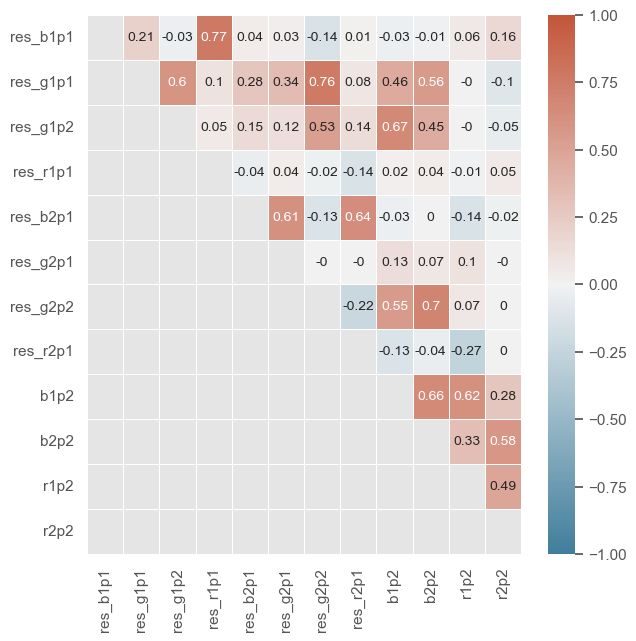

In [157]:
plt.style.use("ggplot")
f, ax = plt.subplots(figsize=(7, 7))
cv= features.corr().round(1)
matrix = np.tril(np.ones_like(cv))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(features.corr().round(2),vmin=-1,vmax=1,annot=True,linewidth=.5, mask=matrix, cmap=cmap)

# Modeling 

## Evaluation competing model

<AxesSubplot:>

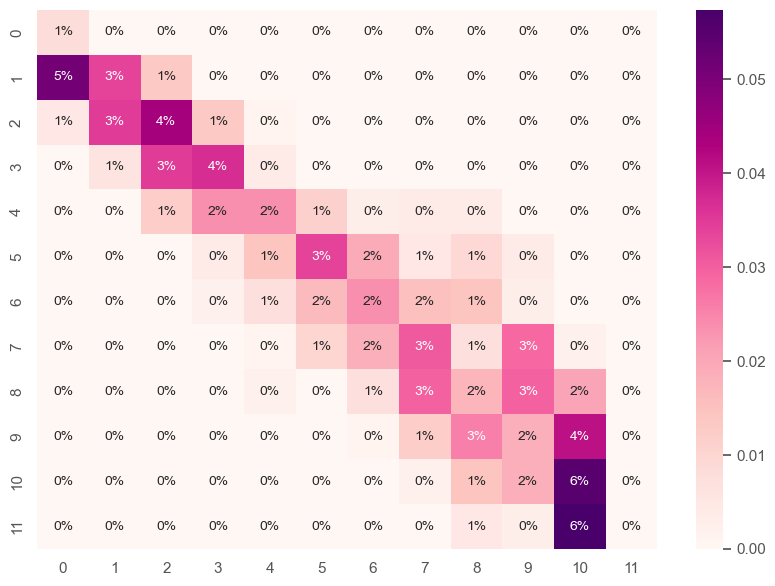

In [158]:
pd.crosstab(dt.flush_case, dt.PCB, rownames=['True'], colnames=['Predicted'], margins=True)
confusionmatrix = confusion_matrix(dt.flush_case,dt.PCB)
sns.heatmap(confusionmatrix/np.sum(confusionmatrix), annot=True,  fmt='1.0%', cmap='RdPu')

## PCA (Only activate when want to evaluate when using PCA)

In [159]:
#from sklearn.decomposition import PCA
#from sklearn.preprocessing import StandardScaler

#Define Scaler 
#sc = StandardScaler()
#features = sc.fit_transform(features)

#Define PCA
#pca = PCA()

#features_1 = pca.fit_transform(features)
#explained_variance = pca.explained_variance_ratio_
#pd.DataFrame(explained_variance, columns= ['exp_var'])
#pd.DataFrame(explained_variance, columns= ['exp_var']).plot.line()

#Define PCA
#pca = PCA(n_components = 5)

#features = pd.DataFrame(pca.fit_transform(features), columns = ['c1','c2','c3','c4','c5'])
#explained_variance = pca.explained_variance_ratio_
#print(np.sum(explained_variance))

## Get train and test data

In [160]:
X = features
#X = sm.add_constant(X)
Y = dt[['flush_case']]
# Define random state for reproducibility
random_state = 0

# Divide data in train and an auxiliar for validation/test randomly, taking the train size as 70% of the whole data
x_train_glob, x_test_glob, y_train_glob, y_test_glob = train_test_split(X, Y, test_size = 0.3, random_state = random_state)

print("X Train shape:",x_train_glob.shape)
print("Y Train shape:",y_train_glob.shape)
print("X Test shape:",x_test_glob.shape)
print("Y Test shape:",y_test_glob.shape)

X Train shape: (683, 12)
Y Train shape: (683, 1)
X Test shape: (293, 12)
Y Test shape: (293, 1)


In [161]:
PCB_test = dt.iloc[y_test_glob.index].PCB

In [162]:
print("Evaluating results of the classification:")
print("Accuracy2 Score for test: {}".format(acc_1(y_test_glob, PCB_test)))
print("Accuracy Score for test: {}".format(accuracy_score(y_test_glob, PCB_test)))
print("Precision Score for test: {}".format(precision_score(y_test_glob, PCB_test, average='weighted',zero_division = 0)))
print("Recall Score for test: {}".format(recall_score(y_test_glob, PCB_test, average='weighted')))
print("F1 Score for test: {}".format(f1_score(y_test_glob, PCB_test, average='weighted')))
y_PCB=PCB_test.values.ravel()
print(spending(y_PCB, 293))

print(spending(dt.flush_case, 976))

Flush_test=dt.iloc[y_test_glob.index].flush_case

print(error(y_PCB, Flush_test, 293))

Evaluating results of the classification:
Accuracy2 Score for test: 0.49829351535836175
Accuracy Score for test: 0.3242320819112628
Precision Score for test: 0.3156469469976528
Recall Score for test: 0.3242320819112628
F1 Score for test: 0.30860202418687055
An automatic toilet using this model will spend on average : 3.5 liter per flush and will therefore cost : 0.01405 € per flush
An automatic toilet using this model will consume : 961675.3 liters per year and will therefore cost : 3846.70137 € per year
None
An automatic toilet using this model will spend on average : 3.7 liter per flush and will therefore cost : 0.0148 € per flush
An automatic toilet using this model will consume : 1012875.0 liters per year and will therefore cost : 4051.5 € per year
None
0 0 0 0 0 0 0 1 3 27 88 95 51 22 4 2 0 0 0 0 0 0 0
None


## Oversampling to overcome imbalanced classes

In [163]:
# Define the oversampler and the replication seed
oversampler = SMOTE(random_state = random_state)
# Apply the Oversampler to the original data
x_oversample_SMT, y_oversample_SMT = oversampler.fit_resample(X, Y)

'''concat_back = pd.concat([x_oversample_SMT,y_oversample_SMT], axis=1)
concat_back = concat_back.groupby('Y', group_keys=False).apply(lambda x: x.sample(1600, random_state = random_state)).reset_index(drop=True)
x_oversample_SMT = concat_back.drop(labels='Y', axis=1)
y_oversample_SMT = concat_back['Y']'''

"concat_back = pd.concat([x_oversample_SMT,y_oversample_SMT], axis=1)\nconcat_back = concat_back.groupby('Y', group_keys=False).apply(lambda x: x.sample(1600, random_state = random_state)).reset_index(drop=True)\nx_oversample_SMT = concat_back.drop(labels='Y', axis=1)\ny_oversample_SMT = concat_back['Y']"

In [164]:
# Divide data in train and an auxiliar for validation/test randomly, taking the train size as 70% of the whole data
x_train_glob_SMT, x_test_glob_SMT, y_train_glob_SMT, y_test_glob_SMT = train_test_split(x_oversample_SMT, y_oversample_SMT, test_size = 0.3, random_state = random_state)

print("======================================================================================")
print("X SMOTE Train shape:",x_train_glob_SMT.shape)
print("Y SMOTE Train shape:",y_train_glob_SMT.shape)
print("X SMOTE Test shape:",x_test_glob_SMT.shape)
print("Y SMOTE Test shape:",y_test_glob_SMT.shape)
print("======================================================================================")

X SMOTE Train shape: (873, 12)
Y SMOTE Train shape: (873, 1)
X SMOTE Test shape: (375, 12)
Y SMOTE Test shape: (375, 1)


Text(0.5, 1.0, 'Class Balance SMT')

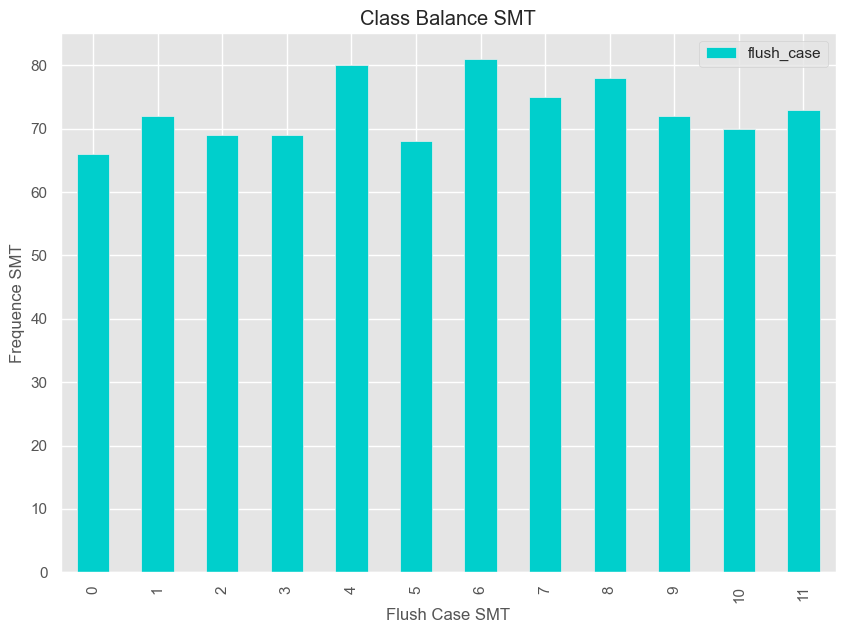

In [165]:
legend = list(np.unique(y_train_glob_SMT))
data = y_train_glob_SMT.flush_case.value_counts().reset_index().sort_values(by='index')
data

data.plot.bar(x='index', y='flush_case', color ="#00cfcc") #Unbalanced classes
plt.xlabel('Flush Case SMT')
plt.ylabel('Frequence SMT')
plt.title(r'Class Balance SMT')

## Applying Ordered Logistic Model

### Training with original data

In [166]:
var_select = x_train_glob.columns

x_train = x_train_glob[var_select]
y_train = y_train_glob
x_test = x_test_glob[var_select]
y_test = y_test_glob

print("X Train shape:",x_train.shape)
print("Y Train shape:",y_train.shape)
print("X Test shape:",x_test.shape)
print("Y Test shape:",y_test.shape)


mod_log = OrderedModel(y_train,x_train,distr='logit')
res_log = mod_log.fit(method='bfgs', disp=False)
print(res_log.summary())
# Predict values of regression with train
ypred_train =np.array(res_log.predict(x_train)).argmax(axis=1)
# Predict values of regression with test

ypred_test = np.array(res_log.predict(x_test)).argmax(axis=1)
print("Evaluating results of the classification:")
print("Accuracy2 Score for train, test: {}, {}".format(acc_1(y_train_glob, ypred_train), acc_1(y_test_glob, ypred_test)))
print("Accuracy Score for train, test: {}, {}".format(accuracy_score(y_train_glob, ypred_train), accuracy_score(y_test_glob, ypred_test)))
print("Precision Score for train, test: {}, {}".format(precision_score(y_train_glob, ypred_train, average='weighted',zero_division = 0), precision_score(y_test_glob, ypred_test, average='weighted',zero_division = 0)))
print("Recall Score for train, test: {}, {}".format(recall_score(y_train_glob.flush_case.values, ypred_train, average='weighted'), recall_score(y_test_glob, ypred_test, average='weighted')))
print("F1 Score for train, test: {}, {}".format(f1_score(y_train_glob, ypred_train, average='weighted'), f1_score(y_test_glob, ypred_test, average='weighted')))

# Multicolinearity
# For each X, calculate VIF and save in dataframe
vif = pd.DataFrame()
aux = x_train
# aux = x_train.copy()
vif["VIF Factor"] = [variance_inflation_factor(aux.values, i) for i in range(aux.shape[1])]
vif["features"] = aux.columns
print("===================================================================================")
print("Multicolinarity check using VIF:")
print(vif.sort_values('VIF Factor',ascending=False).round(1))

X Train shape: (683, 12)
Y Train shape: (683, 1)
X Test shape: (293, 12)
Y Test shape: (293, 1)
                             OrderedModel Results                             
Dep. Variable:             flush_case   Log-Likelihood:                -1017.1
Model:                   OrderedModel   AIC:                             2080.
Method:            Maximum Likelihood   BIC:                             2184.
Date:                Sun, 27 Nov 2022                                         
Time:                        15:09:32                                         
No. Observations:                 683                                         
Df Residuals:                     660                                         
Df Model:                          23                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
res_b1p1       0.0086      0.002   

### Training with SMOTE (Selected model with class balancing)

In [167]:
var_select = x_train_glob.columns

x_train = x_train_glob_SMT[var_select]
y_train = y_train_glob_SMT
x_test = x_test_glob[var_select]
y_test = y_test_glob

print("X Train shape:",x_train.shape)
print("Y Train shape:",y_train.shape)
print("X Test shape:",x_test.shape)
print("Y Test shape:",y_test.shape)


mod_log = OrderedModel(y_train,x_train,distr='logit')
res_log = mod_log.fit(method='bfgs', disp=False)
print(res_log.summary())
# Predict values of regression with train
ypred_train =np.array(res_log.predict(x_train)).argmax(axis=1)
# Predict values of regression with test
ypred_test = np.array(res_log.predict(x_test)).argmax(axis=1)

print("Evaluating results of the classification:")
print("Accuracy2 Score for train, test: {}, {}".format(acc_1(y_train_glob_SMT, ypred_train), acc_1(y_test_glob, ypred_test)))
print("Accuracy Score for train, test: {}, {}".format(accuracy_score(y_train_glob_SMT, ypred_train), accuracy_score(y_test_glob, ypred_test)))
print("Precision Score for train, test: {}, {}".format(precision_score(y_train_glob_SMT, ypred_train, average='weighted',zero_division = 0), precision_score(y_test_glob, ypred_test, average='weighted',zero_division = 0)))
print("Recall Score for train, test: {}, {}".format(recall_score(y_train_glob_SMT.flush_case.values, ypred_train, average='weighted'), recall_score(y_test_glob, ypred_test, average='weighted')))
print("F1 Score for train, test: {}, {}".format(f1_score(y_train_glob_SMT, ypred_train, average='weighted'), f1_score(y_test_glob, ypred_test, average='weighted')))

# Multicolinearity
# For each X, calculate VIF and save in dataframe
vif = pd.DataFrame()
aux = x_train
# aux = x_train.copy()
vif["VIF Factor"] = [variance_inflation_factor(aux.values, i) for i in range(aux.shape[1])]
vif["features"] = aux.columns
print("===================================================================================")
print("Multicolinarity check using VIF:")
print(vif.sort_values('VIF Factor',ascending=False).round(1))

X Train shape: (873, 12)
Y Train shape: (873, 1)
X Test shape: (293, 12)
Y Test shape: (293, 1)
                             OrderedModel Results                             
Dep. Variable:             flush_case   Log-Likelihood:                -1244.0
Model:                   OrderedModel   AIC:                             2534.
Method:            Maximum Likelihood   BIC:                             2644.
Date:                Sun, 27 Nov 2022                                         
Time:                        15:09:33                                         
No. Observations:                 873                                         
Df Residuals:                     850                                         
Df Model:                          23                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
res_b1p1       0.0150      0.002   

## Applying Ordered Probit Model

### Training with original data

In [168]:
var_select = x_train_glob.columns

x_train = x_train_glob[var_select]
y_train = y_train_glob
x_test = x_test_glob[var_select]
y_test = y_test_glob

print("======================================================================================")
print("X Train shape:",x_train.shape)
print("Y Train shape:",y_train.shape)
print("X Test shape:",x_test.shape)
print("Y Test shape:",y_test.shape)


mod_prob = OrderedModel(y_train,x_train,distr='probit')
res_prob = mod_prob.fit(method='bfgs', disp=False)
print(res_prob.summary())
# Predict values of regression with train
ypred_train =np.array(res_prob.predict(x_train)).argmax(axis=1)
# Predict values of regression with test

ypred_test = np.array(res_prob.predict(x_test)).argmax(axis=1)
print("Evaluating results of the classification:")
print("Accuracy2 Score for train, test: {}, {}".format(acc_1(y_train_glob, ypred_train), acc_1(y_test_glob, ypred_test)))
print("Accuracy Score for train, test: {}, {}".format(accuracy_score(y_train_glob, ypred_train), accuracy_score(y_test_glob, ypred_test)))
print("Precision Score for train, test: {}, {}".format(precision_score(y_train_glob, ypred_train, average='weighted',zero_division = 0), precision_score(y_test_glob, ypred_test, average='weighted',zero_division = 0)))
print("Recall Score for train, test: {}, {}".format(recall_score(y_train_glob.flush_case.values, ypred_train, average='weighted'), recall_score(y_test_glob, ypred_test, average='weighted')))
print("F1 Score for train, test: {}, {}".format(f1_score(y_train_glob, ypred_train, average='weighted'), f1_score(y_test_glob, ypred_test, average='weighted')))

# Multicolinearity
# For each X, calculate VIF and save in dataframe
vif = pd.DataFrame()
aux = x_train
# aux = x_train.copy()
vif["VIF Factor"] = [variance_inflation_factor(aux.values, i) for i in range(aux.shape[1])]
vif["features"] = aux.columns
print("===================================================================================")
print("Multicolinarity check using VIF:")
print(vif.sort_values('VIF Factor',ascending=False).round(1))

X Train shape: (683, 12)
Y Train shape: (683, 1)
X Test shape: (293, 12)
Y Test shape: (293, 1)
                             OrderedModel Results                             
Dep. Variable:             flush_case   Log-Likelihood:                -1019.7
Model:                   OrderedModel   AIC:                             2085.
Method:            Maximum Likelihood   BIC:                             2190.
Date:                Sun, 27 Nov 2022                                         
Time:                        15:09:34                                         
No. Observations:                 683                                         
Df Residuals:                     660                                         
Df Model:                          23                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
res_b1p1       0.0048      0.001   

### Training with SMOTE

In [169]:
var_select = x_train_glob.columns

x_train = x_train_glob_SMT[var_select]
y_train = y_train_glob_SMT
x_test = x_test_glob[var_select]
y_test = y_test_glob

print("======================================================================================")
print("X Train shape:",x_train.shape)
print("Y Train shape:",y_train.shape)
print("X Test shape:",x_test.shape)
print("Y Test shape:",y_test.shape)


mod_log = OrderedModel(y_train,x_train,distr='probit')
res_log = mod_log.fit(method='bfgs', disp=False)
print(res_log.summary())
# Predict values of regression with train
ypred_train =np.array(res_log.predict(x_train)).argmax(axis=1)
# Predict values of regression with test
ypred_test = np.array(res_log.predict(x_test)).argmax(axis=1)

print("Accuracy2 Score for train, test: {}, {}".format(acc_1(y_train_glob_SMT, ypred_train), acc_1(y_test_glob, ypred_test)))
print("Accuracy Score for train, test: {}, {}".format(accuracy_score(y_train_glob_SMT, ypred_train), accuracy_score(y_test_glob, ypred_test)))
print("Precision Score for train, test: {}, {}".format(precision_score(y_train_glob_SMT, ypred_train, average='weighted',zero_division = 0), precision_score(y_test_glob, ypred_test, average='weighted',zero_division = 0)))
print("Recall Score for train, test: {}, {}".format(recall_score(y_train_glob_SMT.flush_case.values, ypred_train, average='weighted'), recall_score(y_test_glob, ypred_test, average='weighted')))
print("F1 Score for train, test: {}, {}".format(f1_score(y_train_glob_SMT, ypred_train, average='weighted'), f1_score(y_test_glob, ypred_test, average='weighted')))

# Multicolinearity
# For each X, calculate VIF and save in dataframe
vif = pd.DataFrame()
aux = x_train
# aux = x_train.copy()
vif["VIF Factor"] = [variance_inflation_factor(aux.values, i) for i in range(aux.shape[1])]
vif["features"] = aux.columns
print("===================================================================================")
print("Multicolinarity check using VIF:")
print(vif.sort_values('VIF Factor',ascending=False).round(1))

X Train shape: (873, 12)
Y Train shape: (873, 1)
X Test shape: (293, 12)
Y Test shape: (293, 1)
                             OrderedModel Results                             
Dep. Variable:             flush_case   Log-Likelihood:                -1249.2
Model:                   OrderedModel   AIC:                             2544.
Method:            Maximum Likelihood   BIC:                             2654.
Date:                Sun, 27 Nov 2022                                         
Time:                        15:09:35                                         
No. Observations:                 873                                         
Df Residuals:                     850                                         
Df Model:                          23                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
res_b1p1       0.0079      0.001   

## Applying Lasso regression technique

### Training with original data

In [170]:
var_select = x_train_glob.columns

x_train = x_train_glob[var_select]
y_train = y_train_glob
x_test = x_test_glob[var_select]
y_test = y_test_glob

print("======================================================================================")
print("X Train shape:",x_train.shape)
print("Y Train shape:",y_train.shape)
print("X Test shape:",x_test.shape)
print("Y Test shape:",y_test.shape)


#Define the grid to be searched in  lasso = Lasso(random_state = random_state)

lasso = LogisticRegression(random_state = random_state, penalty='l1', solver='liblinear')

# Create the random grid
#parameters = {'C':[1/1e-6, 1/1e-5, 1/1e-4, 1/1e-3, 1/5e-2, 1/1e-2, 1/1e-1, 1/0.3, 1/0.5, 1/0.7, 1/1.0, 1/10.0, 1/50.0, 1/100.0]}
parameters = {'C':[1/1000, 1/9, 1/3, 1/5, 1/4,1/2, 1/10.0, 1/50.0, 1/100.0 ]}

# Random search of parameters, using 5 fold cross validation, search across 9 different combinations, and use all available cores
lasso_grid = RandomizedSearchCV(estimator = lasso, param_distributions = parameters, n_iter = 9, cv = 5, verbose=False, random_state = random_state, n_jobs = -1)

# Fit the random search model

lasso_grid.fit(x_train, y_train.values.ravel())

print("======================================================================================")
print("Best parameters found: ")
print(lasso_grid.best_params_)


print("======================================================================================")

# Predict values of regression with train
ypred_train = lasso_grid.best_estimator_.predict(x_train)

# Predict values of regression with test
ypred_test = lasso_grid.best_estimator_.predict(x_test)

print("Evaluating results of the classification:")
print("Accuracy2 Score for train, test: {}, {}".format(acc_1(y_train_glob, ypred_train), acc_1(y_test_glob, ypred_test)))
print("Accuracy Score for train, test: {}, {}".format(accuracy_score(y_train_glob, ypred_train), accuracy_score(y_test_glob, ypred_test)))
print("Precision Score for train, test: {}, {}".format(precision_score(y_train_glob, ypred_train, average='weighted',zero_division = 0), precision_score(y_test_glob, ypred_test, average='weighted',zero_division = 0)))
print("Recall Score for train, test: {}, {}".format(recall_score(y_train_glob.flush_case.values, ypred_train, average='weighted'), recall_score(y_test_glob, ypred_test, average='weighted')))
print("F1 Score for train, test: {}, {}".format(f1_score(y_train_glob, ypred_train, average='weighted'), f1_score(y_test_glob, ypred_test, average='weighted')))

# Multicolinearity
# For each X, calculate VIF and save in dataframe
vif = pd.DataFrame()
aux = x_train
# aux = x_train.copy()
vif["VIF Factor"] = [variance_inflation_factor(aux.values, i) for i in range(aux.shape[1])]
vif["features"] = aux.columns
print("===================================================================================")
print("Multicolinarity check using VIF:")
print(vif.sort_values('VIF Factor',ascending=False).round(1))

# Feature importance calculation
# Load model

imps = permutation_importance(lasso_grid.best_estimator_, x_train, y_train)

# Create dummie variables and stack them with the previous dataframe
importance = pd.concat([pd.DataFrame(x_train.columns), pd.DataFrame(imps.importances_mean)], axis=1)
importance.columns = ["variable","importance"]
importance = importance.sort_values(by='importance', ascending=False)
print("======================================================================================")
print("Feature importance:")
print(importance)

X Train shape: (683, 12)
Y Train shape: (683, 1)
X Test shape: (293, 12)
Y Test shape: (293, 1)


/Users/gxxdx/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/gxxdx/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/gxxdx/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/gxxdx/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/gxxdx/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/gxxdx/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1225

Best parameters found: 
{'C': 0.01}
Evaluating results of the classification:
Accuracy2 Score for train, test: 0.6002928257686676, 0.590443686006826
Accuracy Score for train, test: 0.4333821376281113, 0.3993174061433447
Precision Score for train, test: 0.42365091865724114, 0.378932153770441
Recall Score for train, test: 0.4333821376281113, 0.3993174061433447
F1 Score for train, test: 0.4195925393567072, 0.3821821997985366
Multicolinarity check using VIF:
    VIF Factor  features
1        236.8  res_g1p1
4        208.3  res_b2p1
0        159.3  res_b1p1
5        104.8  res_g2p1
2         50.1  res_g1p2
7         44.7  res_r2p1
6         42.9  res_g2p2
3         36.3  res_r1p1
9         14.6      b2p2
11        14.6      r2p2
8         13.2      b1p2
10        10.7      r1p2
Feature importance:
    variable  importance
11      r2p2    0.256808
1   res_g1p1    0.075256
3   res_r1p1    0.066471
9       b2p2    0.048316
6   res_g2p2    0.048316
8       b1p2    0.043924
0   res_b1p1    0.042

/Users/gxxdx/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


### Training with SMOTE data

In [171]:
var_select = x_train_glob.columns

x_train = x_train_glob_SMT[var_select]
y_train = y_train_glob_SMT
x_test = x_test_glob[var_select]
y_test = y_test_glob

print("======================================================================================")
print("X Train shape:",x_train.shape)
print("Y Train shape:",y_train.shape)
print("X Test shape:",x_test.shape)
print("Y Test shape:",y_test.shape)


#Define the grid to be searched in  lasso = Lasso(random_state = random_state)

lasso = LogisticRegression(random_state = random_state, penalty='l1', solver='liblinear')

# Create the random grid
#parameters = {'C':[1/1e-6, 1/1e-5, 1/1e-4, 1/1e-3, 1/5e-2, 1/1e-2, 1/1e-1, 1/0.3, 1/0.5, 1/0.7, 1/1.0, 1/10.0, 1/50.0, 1/100.0]}
parameters = {'C':[1/1000, 1/9, 1/3, 1/5, 1/4,1/2, 1/10.0, 1/50.0, 1/100.0 ]}

# Random search of parameters, using 5 fold cross validation, search across 9 different combinations, and use all available cores

lasso_grid = RandomizedSearchCV(estimator = lasso, param_distributions = parameters, n_iter = 9, cv = 5, verbose=False, random_state = random_state, n_jobs = -1)

# Fit the random search model

lasso_grid.fit(x_train, y_train.values.ravel())

print("======================================================================================")
print("Best parameters found: ")
print(lasso_grid.best_params_)


print("======================================================================================")

# Predict values of regression with train
ypred_train = lasso_grid.best_estimator_.predict(x_train)

# Predict values of regression with test
ypred_test = lasso_grid.best_estimator_.predict(x_test)

print("Evaluating results of the classification:")
print("Accuracy2 Score for train, test: {}, {}".format(acc_1(y_train_glob_SMT, ypred_train), acc_1(y_test_glob, ypred_test)))
print("Accuracy Score for train, test: {}, {}".format(accuracy_score(y_train_glob_SMT, ypred_train), accuracy_score(y_test_glob, ypred_test)))
print("Precision Score for train, test: {}, {}".format(precision_score(y_train_glob_SMT, ypred_train, average='weighted',zero_division = 0), precision_score(y_test_glob, ypred_test, average='weighted',zero_division = 0)))
print("Recall Score for train, test: {}, {}".format(recall_score(y_train_glob_SMT.flush_case.values, ypred_train, average='weighted'), recall_score(y_test_glob, ypred_test, average='weighted')))
print("F1 Score for train, test: {}, {}".format(f1_score(y_train_glob_SMT, ypred_train, average='weighted'), f1_score(y_test_glob, ypred_test, average='weighted')))

# Multicolinearity
# For each X, calculate VIF and save in dataframe
vif = pd.DataFrame()
aux = x_train
# aux = x_train.copy()
vif["VIF Factor"] = [variance_inflation_factor(aux.values, i) for i in range(aux.shape[1])]
vif["features"] = aux.columns
print("===================================================================================")
print("Multicolinarity check using VIF:")
print(vif.sort_values('VIF Factor',ascending=False).round(1))

# Feature importance calculation

imps = permutation_importance(lasso_grid.best_estimator_, x_train, y_train)

# Create dummie variables and stack them with the previous dataframe
importance = pd.concat([pd.DataFrame(x_train.columns), pd.DataFrame(imps.importances_mean)], axis=1)
importance.columns = ["variable","importance"]
importance = importance.sort_values(by='importance', ascending=False)
print("======================================================================================")
print("Feature importance:")
print(importance)

X Train shape: (873, 12)
Y Train shape: (873, 1)
X Test shape: (293, 12)
Y Test shape: (293, 1)


/Users/gxxdx/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/gxxdx/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/gxxdx/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/gxxdx/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Best parameters found: 
{'C': 0.01}
Evaluating results of the classification:
Accuracy2 Score for train, test: 0.6666666666666666, 0.5972696245733788
Accuracy Score for train, test: 0.47995418098510884, 0.3890784982935154
Precision Score for train, test: 0.45938118593037797, 0.3879616820518562
Recall Score for train, test: 0.47995418098510884, 0.3890784982935154
F1 Score for train, test: 0.44643196724722956, 0.3624231158473122
Multicolinarity check using VIF:
    VIF Factor  features
1        251.1  res_g1p1
4        215.0  res_b2p1
0        147.3  res_b1p1
5        103.5  res_g2p1
2         55.4  res_g1p2
6         51.8  res_g2p2
7         47.7  res_r2p1
3         36.9  res_r1p1
9         28.5      b2p2
8         18.4      b1p2
11        16.7      r2p2
10        11.6      r1p2
Feature importance:
    variable  importance
11      r2p2    0.246506
9       b2p2    0.128064
1   res_g1p1    0.084307
3   res_r1p1    0.079954
0   res_b1p1    0.078809
2   res_g1p2    0.053150
10      r1p2    

## Applying Ridge regression technique

## Training with original data

In [172]:
var_select = x_train_glob.columns

x_train = x_train_glob[var_select]
y_train = y_train_glob
x_test = x_test_glob[var_select]
y_test = y_test_glob


print("======================================================================================")
print("X Train shape:",x_train.shape)
print("Y Train shape:",y_train.shape)
print("X Test shape:",x_test.shape)
print("Y Test shape:",y_test.shape)

#Define the grid to be searched in

ridge = RidgeClassifier(random_state = random_state)

# Create the random grid
parameters = {'alpha':[1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 0.0, 0.3,0.7, 1.0, 10.0, 20.0, 30.0, 100.0]}
  
# Random search of parameters, using 5 fold cross validation, search across 100 different combinations, and use all available cores
  
ridge_grid = RandomizedSearchCV(estimator = ridge, param_distributions = parameters, n_iter = 10, cv = 4, verbose=False, random_state = random_state , n_jobs = -1)

# Fit the random search model

ridge_grid.fit(x_train, y_train.values.ravel())

print("======================================================================================")
print("Best parameters found: ")
print(ridge_grid.best_params_)

print("======================================================================================")

# Predict values of regression with train
ypred_train = ridge_grid.best_estimator_.predict(x_train)

# Predict values of regression with test
ypred_test = ridge_grid.best_estimator_.predict(x_test)

print("Evaluating results of the classification:")
print("Accuracy2 Score for train, test: {}, {}".format(acc_1(y_train_glob, ypred_train), acc_1(y_test_glob, ypred_test)))
print("Accuracy Score for train, test: {}, {}".format(accuracy_score(y_train_glob, ypred_train), accuracy_score(y_test_glob, ypred_test)))
print("Precision Score for train, test: {}, {}".format(precision_score(y_train_glob, ypred_train, average='weighted',zero_division = 0), precision_score(y_test_glob, ypred_test, average='weighted',zero_division = 0)))
print("Recall Score for train, test: {}, {}".format(recall_score(y_train_glob.flush_case.values, ypred_train, average='weighted'), recall_score(y_test_glob, ypred_test, average='weighted')))
print("F1 Score for train, test: {}, {}".format(f1_score(y_train_glob, ypred_train, average='weighted'), f1_score(y_test_glob, ypred_test, average='weighted')))
print("======================================================================================")

# Multicolinearity
# For each X, calculate VIF and save in dataframe
vif = pd.DataFrame()
aux = x_train
# aux = x_train.copy()
vif["VIF Factor"] = [variance_inflation_factor(aux.values, i) for i in range(aux.shape[1])]
vif["features"] = aux.columns
print("===================================================================================")
print("Multicolinarity check using VIF:")
print(vif.sort_values('VIF Factor',ascending=False).round(1))

# Feature importance calculation
imps = permutation_importance(ridge_grid.best_estimator_, x_train, y_train)

# Create dummie variables and stack them with the previous dataframe
importance = pd.concat([pd.DataFrame(x_train.columns), pd.DataFrame(imps.importances_mean)], axis=1)
importance.columns = ["variable","importance"]

# importance = importance.sort_values(by='importance', ascending=False)
print("======================================================================================")
print("Feature importance:")
print(importance)

X Train shape: (683, 12)
Y Train shape: (683, 1)
X Test shape: (293, 12)
Y Test shape: (293, 1)
Best parameters found: 
{'alpha': 0.3}
Evaluating results of the classification:
Accuracy2 Score for train, test: 0.4773060029282577, 0.4709897610921502
Accuracy Score for train, test: 0.34260614934114203, 0.3003412969283277
Precision Score for train, test: 0.32760626885135474, 0.2597481297707863
Recall Score for train, test: 0.34260614934114203, 0.3003412969283277
F1 Score for train, test: 0.2905472649474362, 0.2471732523729566
Multicolinarity check using VIF:
    VIF Factor  features
1        236.8  res_g1p1
4        208.3  res_b2p1
0        159.3  res_b1p1
5        104.8  res_g2p1
2         50.1  res_g1p2
7         44.7  res_r2p1
6         42.9  res_g2p2
3         36.3  res_r1p1
9         14.6      b2p2
11        14.6      r2p2
8         13.2      b1p2
10        10.7      r1p2
Feature importance:
    variable  importance
0   res_b1p1    0.036603
1   res_g1p1    0.102196
2   res_g1p2    0.

## Training with SMOTE

In [173]:
var_select = x_train_glob.columns

x_train = x_train_glob_SMT[var_select]
y_train = y_train_glob_SMT
x_test = x_test_glob[var_select]
y_test = y_test_glob

print("======================================================================================")
print("X Train shape:",x_train.shape)
print("Y Train shape:",y_train.shape)
print("X Test shape:",x_test.shape)
print("Y Test shape:",y_test.shape)


#Define the grid to be searched in

ridge = RidgeClassifier(random_state = random_state)

# Create the random grid
parameters = {'alpha':[1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 0.0, 0.3,0.7, 1.0, 10.0, 20.0, 30.0, 100.0]}
  
# Random search of parameters, using 5 fold cross validation, search across 100 different combinations, and use all available cores
  
ridge_grid = RandomizedSearchCV(estimator = ridge, param_distributions = parameters, n_iter = 13, cv = 5, verbose=False, random_state = random_state , n_jobs = -1)

# Fit the random search model

ridge_grid.fit(x_train, y_train.values.ravel())

print("======================================================================================")
print("Best parameters found: ")
print(ridge_grid.best_params_)

print("======================================================================================")

# Predict values of regression with train
ypred_train = ridge_grid.best_estimator_.predict(x_train)

# Predict values of regression with test
ypred_test = ridge_grid.best_estimator_.predict(x_test)

print("Evaluating results of the classification:")
print("Accuracy2 Score for train, test: {}, {}".format(acc_1(y_train_glob_SMT, ypred_train), acc_1(y_test_glob, ypred_test)))
print("Accuracy Score for train, test: {}, {}".format(accuracy_score(y_train_glob_SMT, ypred_train), accuracy_score(y_test_glob, ypred_test)))
print("Precision Score for train, test: {}, {}".format(precision_score(y_train_glob_SMT, ypred_train, average='weighted',zero_division = 0), precision_score(y_test_glob, ypred_test, average='weighted',zero_division = 0)))
print("Recall Score for train, test: {}, {}".format(recall_score(y_train_glob_SMT.flush_case.values, ypred_train, average='weighted'), recall_score(y_test_glob, ypred_test, average='weighted')))
print("F1 Score for train, test: {}, {}".format(f1_score(y_train_glob_SMT, ypred_train, average='weighted'), f1_score(y_test_glob, ypred_test, average='weighted')))
print("======================================================================================")

# Multicolinearity
# For each X, calculate VIF and save in dataframe
vif = pd.DataFrame()
aux = x_train
# aux = x_train.copy()
vif["VIF Factor"] = [variance_inflation_factor(aux.values, i) for i in range(aux.shape[1])]
vif["features"] = aux.columns
print("===================================================================================")
print("Multicolinarity check using VIF:")
print(vif.sort_values('VIF Factor',ascending=False).round(1))

# Feature importance calculation
imps = permutation_importance(ridge_grid.best_estimator_, x_train, y_train)

# Create dummie variables and stack them with the previous dataframe
importance = pd.concat([pd.DataFrame(x_train.columns), pd.DataFrame(imps.importances_mean)], axis=1)
importance.columns = ["variable","importance"]

# importance = importance.sort_values(by='importance', ascending=False)
print("======================================================================================")
print("Feature importance:")
print(importance)

X Train shape: (873, 12)
Y Train shape: (873, 1)
X Test shape: (293, 12)
Y Test shape: (293, 1)
Best parameters found: 
{'alpha': 100.0}
Evaluating results of the classification:
Accuracy2 Score for train, test: 0.5120274914089347, 0.4232081911262799
Accuracy Score for train, test: 0.3768613974799542, 0.2832764505119454
Precision Score for train, test: 0.3242107214502572, 0.2815721763191715
Recall Score for train, test: 0.3768613974799542, 0.2832764505119454
F1 Score for train, test: 0.29781836532322775, 0.23363225063599832
Multicolinarity check using VIF:
    VIF Factor  features
1        251.1  res_g1p1
4        215.0  res_b2p1
0        147.3  res_b1p1
5        103.5  res_g2p1
2         55.4  res_g1p2
6         51.8  res_g2p2
7         47.7  res_r2p1
3         36.9  res_r1p1
9         28.5      b2p2
8         18.4      b1p2
11        16.7      r2p2
10        11.6      r1p2
Feature importance:
    variable  importance
0   res_b1p1    0.083620
1   res_g1p1    0.100802
2   res_g1p2    0

# Multinomial Logit

## Training with the original data

In [174]:
var_select = x_train_glob.columns
x_train = x_train_glob[var_select]
x_train = x_train_glob
y_train = y_train_glob
x_test = x_test_glob[var_select]
y_test = y_test_glob


print("======================================================================================")
print("X Train shape:",x_train.shape)
print("Y Train shape:",y_train.shape)
print("X Test shape:",x_test.shape)
print("Y Test shape:",y_test.shape)


Mlogit = LogisticRegression(multi_class='multinomial', fit_intercept=True, solver='saga', max_iter=10000, random_state = random_state)

#Define the model
Mlogit.fit(x_train, y_train.values.ravel())

#Fitting the model

# Predict values of regression with train
ypred_train = Mlogit.predict(x_train)

# Predict values of regression with test
ypred_test = Mlogit.predict(x_test)

print("Evaluating results of the classification:")

print("Accuracy2 Score for train, test: {}, {}".format(acc_1(y_train, ypred_train), acc_1(y_test, ypred_test)))
print("Accuracy Score for train, test: {}, {}".format(accuracy_score(y_train, ypred_train), accuracy_score(y_test, ypred_test)))
print("Precision Score for train, test: {}, {}".format(precision_score(y_train, ypred_train, average='weighted',zero_division = 0), precision_score(y_test, ypred_test, average='weighted',zero_division = 0)))
print("Recall Score for train, test: {}, {}".format(recall_score(y_train.flush_case.values, ypred_train, average='weighted'), recall_score(y_test, ypred_test, average='weighted')))
print("F1 Score for train, test: {}, {}".format(f1_score(y_train, ypred_train, average='weighted'), f1_score(y_test, ypred_test, average='weighted')))

# Multicolinearity
# For each X, calculate VIF and save in dataframe
#vif = pd.DataFrame()
#aux = x_train
# aux = x_train.copy()
#vif["VIF Factor"] = [variance_inflation_factor(aux.values, i) for i in range(aux.shape[1])]
#vif["features"] = aux.columns
#print("===================================================================================")
#print("Multicolinarity check using VIF:")
#print(vif.sort_values('VIF Factor',ascending=False).round(1))

# Feature importance calculation

#imps = permutation_importance(lasso_grid.best_estimator_, x_train, y_train)

# Create dummie variables and stack them with the previous dataframe
#importance = pd.concat([pd.DataFrame(x_train.columns), pd.DataFrame(imps.importances_mean)], axis=1)
#importance.columns = ["variable","importance"]
#importance = importance.sort_values(by='importance', ascending=False)
#print("======================================================================================")
#print("Feature importance:")
#print(importance)

X Train shape: (683, 12)
Y Train shape: (683, 1)
X Test shape: (293, 12)
Y Test shape: (293, 1)
Evaluating results of the classification:
Accuracy2 Score for train, test: 0.6969253294289898, 0.6484641638225256
Accuracy Score for train, test: 0.49487554904831627, 0.4334470989761092
Precision Score for train, test: 0.4919561897891056, 0.4420485808086705
Recall Score for train, test: 0.49487554904831627, 0.4334470989761092
F1 Score for train, test: 0.4916072603491132, 0.43382381746048726


## Training with SMOTE

In [179]:
var_select = x_train_glob.columns

x_train = x_train_glob_SMT[var_select]
y_train = y_train_glob_SMT
x_test = x_test_glob[var_select]
y_test = y_test_glob

print("======================================================================================")
print("X Train shape:",x_train.shape)
print("Y Train shape:",y_train.shape)
print("X Test shape:",x_test.shape)
print("Y Test shape:",y_test.shape)

Mlogit = LogisticRegression(multi_class='multinomial', fit_intercept=True, solver='saga', max_iter=10000, random_state = 0)

#Define the model
Mlogit.fit(x_train, y_train.values.ravel())

#Fitting the model

# Predict values of regression with train
ypred_train = Mlogit.predict(x_train)

# Predict values of regression with test
ypred_test = Mlogit.predict(x_test)

print("Evaluating results of the classification:")

print("Accuracy2 Score for train, test: {}, {}".format(acc_1(y_train_glob_SMT, ypred_train), acc_1(y_test_glob, ypred_test)))
print("Accuracy Score for train, test: {}, {}".format(accuracy_score(y_train_glob_SMT, ypred_train), accuracy_score(y_test_glob, ypred_test)))
print("Precision Score for train, test: {}, {}".format(precision_score(y_train_glob_SMT, ypred_train, average='weighted',zero_division = 0), precision_score(y_test_glob, ypred_test, average='weighted',zero_division = 0)))
print("Recall Score for train, test: {}, {}".format(recall_score(y_train_glob_SMT.flush_case.values, ypred_train, average='weighted'), recall_score(y_test_glob, ypred_test, average='weighted')))
print("F1 Score for train, test: {}, {}".format(f1_score(y_train_glob_SMT, ypred_train, average='weighted'), f1_score(y_test_glob, ypred_test, average='weighted')))

print(spending(ypred_test, 293))

# Create dummie variables and stack them with the previous dataframe
importance = pd.concat([pd.DataFrame(x_train.columns), pd.DataFrame(imps.importances_mean)], axis=1)
importance.columns = ["variable","importance"]
importance = importance.sort_values(by='importance', ascending=False)
#print("======================================================================================")
print("Feature importance:")
print(importance)
#print("======================================================================================")
print("Dispersion error:")
print(error(ypred_test, Flush_test, 293))

X Train shape: (873, 12)
Y Train shape: (873, 1)
X Test shape: (293, 12)
Y Test shape: (293, 1)
Evaluating results of the classification:
Accuracy2 Score for train, test: 0.7514318442153494, 0.6860068259385665
Accuracy Score for train, test: 0.5475372279495991, 0.4709897610921502
Precision Score for train, test: 0.5426493892495554, 0.4930732465359286
Recall Score for train, test: 0.5475372279495991, 0.4709897610921502
F1 Score for train, test: 0.5416630365002891, 0.4731035611188552
An automatic toilet using this model will spend on average : 3.7 liter per flush and will therefore cost : 0.01494 € per flush
An automatic toilet using this model will consume : 1022498.3 liters per year and will therefore cost : 4089.99317 € per year
None
Feature importance:
    variable  importance
11      r2p2    0.127606
9       b2p2    0.102864
1   res_g1p1    0.100802
0   res_b1p1    0.083620
6   res_g2p2    0.059336
10      r1p2    0.046964
3   res_r1p1    0.045132
2   res_g1p2    0.037113
7   res_r2

# (Selected Model) Multinomial logistic with Elastic-Net penalty

## Training with original data

In [176]:
from sklearn.linear_model import LogisticRegressionCV

var_select = x_train_glob.columns

x_train = x_train_glob[var_select]
y_train = y_train_glob
x_test = x_test_glob[var_select]
y_test = y_test_glob

print("X Train shape:",x_train.shape)
print("Y Train shape:",y_train.shape)
print("X Test shape:",x_test.shape)
print("Y Test shape:",y_test.shape)

print("======================================================================================")

#Define the model

elasticnet = LogisticRegression(random_state = random_state, penalty='elasticnet', solver = 'saga', max_iter=8000)

# Create the random grid
#parameters = {'C':[1/1e-6, 1/1e-5, 1/1e-4, 1/1e-3, 1/5e-2, 1/1e-2, 1/1e-1, 1/0.3, 1/0.5, 1/0.7, 1/1.0, 1/10.0, 1/50.0, 1/100.0],'l1_ratio': np.arange(0, 1, 0.01)}
parameters = {'C':[1/1000, 1/9, 1/3, 1/5, 1/4,1/2, 1/10.0, 1/50.0, 1/100.0 ],'l1_ratio': np.arange(0, 1, 0.01)}
# Random search of parameters, using 5 fold cross validation, search across 100 different combinations, and use all available cores
elasticnet_grid = RandomizedSearchCV(estimator = elasticnet, param_distributions = parameters, n_iter = 10, cv = 5, verbose=False, random_state = random_state , n_jobs = -1)

# Fit the random search model
elasticnet_grid.fit(x_train, y_train.values.ravel())
  
print("======================================================================================")
print("Best parameters found: ")
print(elasticnet_grid.best_params_)
print("======================================================================================")



# Predict values of regression with train
ypred_train = elasticnet_grid.predict(x_train)
# Predict values of regression with test
ypred_test = elasticnet_grid.predict(x_test)

print("Evaluating results of the classification:")

#print("Accuracy2 Score for train, test: {}, {}".format(acc_1(y_train_glob, ypred_train), acc_1(y_test_glob, ypred_test)))
print("Accuracy Score for train, test: {}, {}".format(accuracy_score(y_train_glob, ypred_train), accuracy_score(y_test_glob, ypred_test)))
print("Precision Score for train, test: {}, {}".format(precision_score(y_train_glob, ypred_train, average='weighted',zero_division = 0), precision_score(y_test_glob, ypred_test, average='weighted',zero_division = 0)))
print("Recall Score for train, test: {}, {}".format(recall_score(y_train_glob.flush_case.values, ypred_train, average='weighted'), recall_score(y_test_glob, ypred_test, average='weighted')))
print("F1 Score for train, test: {}, {}".format(f1_score(y_train_glob, ypred_train, average='weighted'), f1_score(y_test_glob, ypred_test, average='weighted')))

print(error(ypred_test, Flush_test, 293))

# Multicolinearity
# For each X, calculate VIF and save in dataframe
#vif = pd.DataFrame()
#aux = x_train
# aux = x_train.copy()
#vif["VIF Factor"] = [variance_inflation_factor(aux.values, i) for i in range(aux.shape[1])]
#vif["features"] = aux.columns
#print("===================================================================================")
#print("Multicolinarity check using VIF:")
#print(vif.sort_values('VIF Factor',ascending=False).round(1))

# Feature importance calculation

#imps = permutation_importance(lasso_grid.best_estimator_, x_train, y_train)

# Create dummie variables and stack them with the previous dataframe
#importance = pd.concat([pd.DataFrame(x_train.columns), pd.DataFrame(imps.importances_mean)], axis=1)
#importance.columns = ["variable","importance"]
#importance = importance.sort_values(by='importance', ascending=False)
#print("======================================================================================")
#print("Feature importance:")
#print(importance)

X Train shape: (683, 12)
Y Train shape: (683, 1)
X Test shape: (293, 12)
Y Test shape: (293, 1)
Best parameters found: 
{'l1_ratio': 0.93, 'C': 0.5}
Evaluating results of the classification:
Accuracy Score for train, test: 0.49487554904831627, 0.4334470989761092
Precision Score for train, test: 0.4921879074310732, 0.44297763575679094
Recall Score for train, test: 0.49487554904831627, 0.4334470989761092
F1 Score for train, test: 0.4917976702075633, 0.434106222450891
0 0 0 0 0 0 0 2 0 12 54 127 64 22 10 2 0 0 0 0 0 0 0
None


## Training with SMOTE

In [177]:
from sklearn.linear_model import LogisticRegressionCV

var_select = x_train_glob.columns

x_train = x_train_glob_SMT[var_select]
y_train = y_train_glob_SMT
x_test = x_test_glob[var_select]
y_test = y_test_glob

print("X Train shape:",x_train.shape)
print("Y Train shape:",y_train.shape)
print("X Test shape:",x_test.shape)
print("Y Test shape:",y_test.shape)

print("======================================================================================")

#Define the model

elasticnet = LogisticRegression(random_state = random_state, penalty='elasticnet', solver = 'saga', max_iter=8000)

# Create the random grid
#parameters = {'C':[1/1e-6, 1/1e-5, 1/1e-4, 1/1e-3, 1/5e-2, 1/1e-2, 1/1e-1, 1/0.3, 1/0.5, 1/0.7, 1/1.0, 1/10.0, 1/50.0, 1/100.0],'l1_ratio': np.arange(0, 1, 0.01)}
parameters = {'C':[1/1000, 1/9, 1/3, 1/5, 1/4,1/2, 1/10.0, 1/50.0, 1/100.0 ],'l1_ratio': np.arange(0, 1, 0.01)}
# Random search of parameters, using 5 fold cross validation, search across 100 different combinations, and use all available cores
elasticnet_grid = RandomizedSearchCV(estimator = elasticnet, param_distributions = parameters, n_iter = 10, cv = 5, verbose=False, random_state = random_state , n_jobs = -1)

# Fit the random search model
elasticnet_grid.fit(x_train, y_train.values.ravel())
  
print("======================================================================================")
print("Best parameters found: ")
print(elasticnet_grid.best_params_)
print("======================================================================================")



# Predict values of regression with train
ypred_train = elasticnet_grid.predict(x_train)
# Predict values of regression with test
ypred_test = elasticnet_grid.predict(x_test)

print("Evaluating results of the classification:")

print("Accuracy2 Score for train, test: {}, {}".format(acc_1(y_train_glob_SMT, ypred_train), acc_1(y_test_glob, ypred_test)))
print("Accuracy Score for train, test: {}, {}".format(accuracy_score(y_train_glob_SMT, ypred_train), accuracy_score(y_test_glob, ypred_test)))
print("Precision Score for train, test: {}, {}".format(precision_score(y_train_glob_SMT, ypred_train, average='weighted',zero_division = 0), precision_score(y_test_glob, ypred_test, average='weighted',zero_division = 0)))
print("Recall Score for train, test: {}, {}".format(recall_score(y_train_glob_SMT.flush_case.values, ypred_train, average='weighted'), recall_score(y_test_glob, ypred_test, average='weighted')))
print("F1 Score for train, test: {}, {}".format(f1_score(y_train_glob_SMT, ypred_train, average='weighted'), f1_score(y_test_glob, ypred_test, average='weighted')))

print(error(ypred_test, Flush_test, 293))

X Train shape: (873, 12)
Y Train shape: (873, 1)
X Test shape: (293, 12)
Y Test shape: (293, 1)
Best parameters found: 
{'l1_ratio': 0.09, 'C': 0.25}
Evaluating results of the classification:
Accuracy2 Score for train, test: 0.7525773195876289, 0.689419795221843
Accuracy Score for train, test: 0.5498281786941581, 0.47440273037542663
Precision Score for train, test: 0.5448979149803262, 0.4968322739385949
Recall Score for train, test: 0.5498281786941581, 0.47440273037542663
F1 Score for train, test: 0.5439323745019748, 0.4767913910988702
0 0 0 0 0 0 0 2 0 13 40 139 63 25 11 0 0 0 0 0 0 0 0
None


# OLS


## Training with original data

In [178]:
var_select = x_train_glob.columns

x_train = x_train_glob[var_select]
x_train = sm.add_constant(x_train)
y_train = y_train_glob
x_test = x_test_glob[var_select]
x_test = sm.add_constant(x_test)
y_test = y_test_glob

print("X Train shape:",x_train.shape)
print("Y Train shape:",y_train.shape)
print("X Test shape:",x_test.shape)
print("Y Test shape:",y_test.shape)

print("======================================================================================")


# Define model
lm = sm.OLS(y_train, x_train)
# Fit model
results = lm.fit()
print(results.summary())

# Checking assumptions
# Multicolinearity
# For each X, calculate VIF and save in dataframe
vif = pd.DataFrame()
aux = x_train.drop(['const'],axis=1)
# aux = x_train.copy()
vif["VIF Factor"] = [variance_inflation_factor(aux.values, i) for i in range(aux.shape[1])]
vif["features"] = aux.columns
print("======================================================================================")
print("Multicolinarity check using VIF:")
print(vif.sort_values('VIF Factor',ascending=False).round(1))

# Get residuals
residuals = results.resid

# Independence of errors
print("======================================================================================")
print("Independence of errors check using Durbin-Watson test:")
dw_stats = sm.stats.stattools.durbin_watson(residuals, axis=0)
print("D-W statistic:", dw_stats)
if dw_stats <= 2.5 and dw_stats >= 1.5:
  print("Residuals are independent")
else:
  print("Residuals are NOT independent")

# Homocedasticity
fvalue, f_pvalue, ordering = sm.stats.diagnostic.het_goldfeldquandt(y_train_glob, x_train_glob)
print("======================================================================================")
print("Homocedasticity check using Goldfeld-Quandt test:")
print("F-value",fvalue,"P-value", f_pvalue)

print("======================================================================================")


# Predict values of regression with train
ypred_train = round(results.predict(x_train),0)
# Predict values of regression with test
ypred_test = round(results.predict(x_test),0)

y_train= y_train.squeeze()
y_test= y_test.squeeze()


print("Evaluating results of the regression:")
print("RMSE Score for train, test: {}, {}".format(rmse(y_train, ypred_train), rmse(y_test, ypred_test)))

print("======================================================================================")

print("Evaluating results of the classification:")
print("Accuracy Score for train, test: {}, {}".format(acc_1(y_train_glob, ypred_train), acc_1(y_test_glob, ypred_test)))
print("Accuracy Score for train, test: {}, {}".format(accuracy_score(y_train_glob, ypred_train), accuracy_score(y_test_glob, ypred_test)))
print("Precision Score for train, test: {}, {}".format(precision_score(y_train_glob, ypred_train, average='weighted',zero_division = 0), precision_score(y_test_glob, ypred_test, average='weighted',zero_division = 0)))
print("Recall Score for train, test: {}, {}".format(recall_score(y_train_glob.flush_case.values, ypred_train, average='weighted'), recall_score(y_test_glob, ypred_test, average='weighted')))
print("F1 Score for train, test: {}, {}".format(f1_score(y_train_glob, ypred_train, average='weighted'), f1_score(y_test_glob, ypred_test, average='weighted')))

X Train shape: (683, 13)
Y Train shape: (683, 1)
X Test shape: (293, 13)
Y Test shape: (293, 1)
                            OLS Regression Results                            
Dep. Variable:             flush_case   R-squared:                       0.850
Model:                            OLS   Adj. R-squared:                  0.848
Method:                 Least Squares   F-statistic:                     317.1
Date:                Sun, 27 Nov 2022   Prob (F-statistic):          8.41e-267
Time:                        15:10:16   Log-Likelihood:                -1101.5
No. Observations:                 683   AIC:                             2229.
Df Residuals:                     670   BIC:                             2288.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------

/Users/gxxdx/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/gxxdx/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
